In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline

In [2]:
df_initial = pd.read_csv('/Users/meghaamar/Downloads/customer_segmentation_data.csv', encoding="ISO-8859-1", dtype={'CustomerID': str,'InvoiceID': str})

In [3]:
df_initial

InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

            InvoiceDate  UnitPrice CustomerID         Country  
0        12/1/2010 8:26       2.55      17850  United Kingdom  
1        12/1/2010 8:26       3.39      17850  United Kingdom  
2        12/1/2010 8:26       2.75      17850  United Kingdom  
3        12/1/2010 8:26       3.39      17850  United Kingdom  
4        12/1/2010 8:26       3.39      17850  United Kingdom  
...                 ...        ...        ...             ...  
541904  12/9/2011 12:50       0.85      12680          France  
541905  12/9/2011 12:50       2.10      12680          France  
541906  12/9/2011 12:50       4.15      12680          France  
541907  12/9/2011 12:50       4.15      12680          France  
541908  12/9/2011 12:50       4.95      12680          France  

[541909 rows x 8 columns]

In [4]:
df_initial.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID      object
Country         object
dtype: object

In [5]:
print(f'Dataframe dimensions: {df_initial.shape}')

Dataframe dimensions: (541909, 8)


In [6]:
df_initial['InvoiceDate'] = pd.to_datetime(df_initial['InvoiceDate'])

In [7]:
column_type=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
column_type.head()

InvoiceNo StockCode Description Quantity     InvoiceDate  \
column type    object    object      object    int64  datetime64[ns]   

            UnitPrice CustomerID Country  
column type   float64     object  object

In [8]:
nulls_df = pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0: 'null values (nb)'})
nulls_df

InvoiceNo  StockCode  Description  Quantity  InvoiceDate  \
null values (nb)          0          0         1454         0            0   

                  UnitPrice  CustomerID  Country  
null values (nb)          0      135080        0

In [9]:
nulls_percentage=pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.rename(index={0:'null values (%)'})
nulls_percentage


InvoiceNo  StockCode  Description  Quantity  InvoiceDate  \
null values (%)        0.0        0.0     0.268311       0.0          0.0   

                 UnitPrice  CustomerID  Country  
null values (%)        0.0   24.926694      0.0

In [10]:
tab_info = pd.concat([column_type, pd.concat([nulls_df, nulls_percentage], axis=0)], axis=0)
tab_info

InvoiceNo StockCode Description Quantity     InvoiceDate  \
column type         object    object      object    int64  datetime64[ns]   
null values (nb)       0.0       0.0      1454.0      0.0             0.0   
null values (%)        0.0       0.0    0.268311      0.0             0.0   

                 UnitPrice CustomerID Country  
column type        float64     object  object  
null values (nb)       0.0   135080.0     0.0  
null values (%)        0.0  24.926694     0.0

In [11]:
df_initial

InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

               InvoiceDate  UnitPrice CustomerID         Country  
0      2010-12-01 08:26:00       2.55      17850  United Kingdom  
1      2010-12-01 08:26:00       3.39      17850  United Kingdom  
2      2010-12-01 08:26:00       2.75      17850  United Kingdom  
3      2010-12-01 08:26:00       3.39      17850  United Kingdom  
4      2010-12-01 08:26:00       3.39      17850  United Kingdom  
...                    ...        ...        ...             ...  
541904 2011-12-09 12:50:00       0.85      12680          France  
541905 2011-12-09 12:50:00       2.10      12680          France  
541906 2011-12-09 12:50:00       4.15      12680          France  
541907 2011-12-09 12:50:00       4.15      12680          France  
541908 2011-12-09 12:50:00       4.95      12680          France  

[541909 rows x 8 columns]

In [12]:
df_initial.dropna(axis=0, subset=['CustomerID'], inplace=True)

In [13]:
df_initial

InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

               InvoiceDate  UnitPrice CustomerID         Country  
0      2010-12-01 08:26:00       2.55      17850  United Kingdom  
1      2010-12-01 08:26:00       3.39      17850  United Kingdom  
2      2010-12-01 08:26:00       2.75      17850  United Kingdom  
3      2010-12-01 08:26:00       3.39      17850  United Kingdom  
4      2010-12-01 08:26:00       3.39      17850  United Kingdom  
...                    ...        ...        ...             ...  
541904 2011-12-09 12:50:00       0.85      12680          France  
541905 2011-12-09 12:50:00       2.10      12680          France  
541906 2011-12-09 12:50:00       4.15      12680          France  
541907 2011-12-09 12:50:00       4.15      12680          France  
541908 2011-12-09 12:50:00       4.95      12680          France  

[406829 rows x 8 columns]

In [14]:
df_initial.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [15]:
column_type=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
nulls_df = pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0: 'null values (nb)'})
nulls_percentage=pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.rename(index={0:'null values (%)'})
tab_info = pd.concat([column_type, pd.concat([nulls_df, nulls_percentage], axis=0)], axis=0)
tab_info


InvoiceNo StockCode Description Quantity     InvoiceDate  \
column type         object    object      object    int64  datetime64[ns]   
null values (nb)       0.0       0.0         0.0      0.0             0.0   
null values (%)        0.0       0.0         0.0      0.0             0.0   

                 UnitPrice CustomerID Country  
column type        float64     object  object  
null values (nb)       0.0        0.0     0.0  
null values (%)        0.0        0.0     0.0

In [16]:
df_initial.duplicated().sum()

5225

In [17]:
df_initial.drop_duplicates(inplace=True)

In [18]:
df_initial

InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

               InvoiceDate  UnitPrice CustomerID         Country  
0      2010-12-01 08:26:00       2.55      17850  United Kingdom  
1      2010-12-01 08:26:00       3.39      17850  United Kingdom  
2      2010-12-01 08:26:00       2.75      17850  United Kingdom  
3      2010-12-01 08:26:00       3.39      17850  United Kingdom  
4      2010-12-01 08:26:00       3.39      17850  United Kingdom  
...                    ...        ...        ...             ...  
541904 2011-12-09 12:50:00       0.85      12680          France  
541905 2011-12-09 12:50:00       2.10      12680          France  
541906 2011-12-09 12:50:00       4.15      12680          France  
541907 2011-12-09 12:50:00       4.15      12680          France  
541908 2011-12-09 12:50:00       4.95      12680          France  

[401604 rows x 8 columns]

In [19]:
temp = df_initial[['InvoiceNo', 'CustomerID', 'Country']].groupby(['InvoiceNo', 'CustomerID', 'Country']).size().reset_index(name='count')
temp

InvoiceNo CustomerID         Country  count
0        536365      17850  United Kingdom      7
1        536366      17850  United Kingdom      2
2        536367      13047  United Kingdom     12
3        536368      13047  United Kingdom      4
4        536369      13047  United Kingdom      1
...         ...        ...             ...    ...
22185   C581484      16446  United Kingdom      1
22186   C581490      14397  United Kingdom      2
22187   C581499      15498  United Kingdom      1
22188   C581568      15311  United Kingdom      1
22189   C581569      17315  United Kingdom      2

[22190 rows x 4 columns]

In [20]:
countries = temp['Country'].value_counts()
countries_percentage = temp['Country'].value_counts(normalize=True)
print(countries)
print(countries_percentage)
print('No. of countries in the dataframe:{}'.format(len(countries)))

Country
United Kingdom          19857
Germany                   603
France                    458
EIRE                      319
Belgium                   119
Spain                     105
Netherlands               101
Switzerland                71
Portugal                   70
Australia                  69
Italy                      55
Finland                    48
Sweden                     46
Norway                     40
Channel Islands            33
Japan                      28
Poland                     24
Denmark                    21
Cyprus                     20
Austria                    19
Singapore                  10
Malta                      10
Unspecified                 8
Iceland                     7
USA                         7
Canada                      6
Greece                      6
Israel                      6
European Community          5
Czech Republic              5
Lithuania                   4
United Arab Emirates        3
Saudi Arabia                2
Ba

In [21]:
df_initial['Country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Greece', 'Singapore', 'Lebanon',
       'United Arab Emirates', 'Saudi Arabia', 'Czech Republic', 'Canada',
       'Unspecified', 'Brazil', 'USA', 'European Community', 'Bahrain',
       'Malta', 'RSA'], dtype=object)

In [22]:
data = dict(type='choropleth',
locations = countries_percentage.index,
locationmode = 'country names', z = countries_percentage,
text = countries_percentage.index, colorbar = {'title':'Order no.'},
colorscale=[[0, 'rgb(224,255,255)'],
            [0.01, 'rgb(166,206,227)'], [0.02, 'rgb(31,120,180)'],
            [0.03, 'rgb(178,223,138)'], [0.05, 'rgb(51,160,44)'],
            [0.10, 'rgb(251,154,153)'], [0.20, 'rgb(255,255,0)'],
            [1, 'rgb(227,26,28)']],    
reversescale = False)
data

{'type': 'choropleth',
 'locations': Index(['United Kingdom', 'Germany', 'France', 'EIRE', 'Belgium', 'Spain',
        'Netherlands', 'Switzerland', 'Portugal', 'Australia', 'Italy',
        'Finland', 'Sweden', 'Norway', 'Channel Islands', 'Japan', 'Poland',
        'Denmark', 'Cyprus', 'Austria', 'Singapore', 'Malta', 'Unspecified',
        'Iceland', 'USA', 'Canada', 'Greece', 'Israel', 'European Community',
        'Czech Republic', 'Lithuania', 'United Arab Emirates', 'Saudi Arabia',
        'Bahrain', 'Brazil', 'Lebanon', 'RSA'],
       dtype='object', name='Country'),
 'locationmode': 'country names',
 'z': Country
 United Kingdom          0.894863
 Germany                 0.027174
 France                  0.020640
 EIRE                    0.014376
 Belgium                 0.005363
 Spain                   0.004732
 Netherlands             0.004552
 Switzerland             0.003200
 Portugal                0.003155
 Australia               0.003110
 Italy                   0.002

In [23]:
layout = dict(title='Number of orders per country',
geo = dict(showframe = True, projection={'type':'mercator'}))

layout

{'title': 'Number of orders per country',
 'geo': {'showframe': True, 'projection': {'type': 'mercator'}}}

In [24]:
# data = dict(type='choropleth',
# locations = countries.index,
# locationmode = 'country names', z = countries,
# text = countries.index, colorbar = {'title':'Order no.'},
# colorscale=[[0, 'rgb(224,255,255)'],
#             [0.01, 'rgb(166,206,227)'], [0.02, 'rgb(31,120,180)'],
#             [0.03, 'rgb(178,223,138)'], [0.05, 'rgb(51,160,44)'],
#             [0.10, 'rgb(251,154,153)'], [0.20, 'rgb(255,255,0)'],
#             [1, 'rgb(227,26,28)']],    
# reversescale = False)
# #_______________________
# layout = dict(title='Number of orders per country',
# geo = dict(showframe = True, projection={'type':'mercator'}))
#______________
choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate=False)

number of users and products

In [25]:
df = pd.DataFrame(df_initial[['CustomerID', 'StockCode', 'InvoiceNo']].nunique()).T
df.rename(columns = {'CustomerID' : 'Customers', 'StockCode' : 'Products', 'InvoiceNo' : 'Transactions'} , inplace=True)

In [26]:
df

Customers  Products  Transactions
0       4372      3684         22190

No of products purchased in every transactions

In [27]:
df_prod = df_initial[['CustomerID', 'StockCode', 'InvoiceNo']].groupby(['CustomerID', 'InvoiceNo']).count().reset_index(drop=False)
df_prod.rename(columns = {'CustomerID' : 'Customers', 'StockCode' : 'Product', 'InvoiceNo' : 'Transaction'}, inplace=True)
df_prod

Customers Transaction  Product
0         12346      541431        1
1         12346     C541433        1
2         12347      537626       31
3         12347      542237       29
4         12347      549222       24
...         ...         ...      ...
22185     18283      579673       50
22186     18283      580872       50
22187     18287      554065       29
22188     18287      570715       38
22189     18287      573167        3

[22190 rows x 3 columns]

The existence of entries with the prefix C for the InvoiceNo variable: this indicates transactions that have been canceled

In [28]:
df_prod['Cancelled Orders'] = df_prod['Transaction'].str.startswith('C')

In [29]:
df_prod

Customers Transaction  Product  Cancelled Orders
0         12346      541431        1             False
1         12346     C541433        1              True
2         12347      537626       31             False
3         12347      542237       29             False
4         12347      549222       24             False
...         ...         ...      ...               ...
22185     18283      579673       50             False
22186     18283      580872       50             False
22187     18287      554065       29             False
22188     18287      570715       38             False
22189     18287      573167        3             False

[22190 rows x 4 columns]

In [30]:
df_prod['Cancelled Orders_1'] = df_prod['Transaction'].apply(lambda x: int('C' in x))
df_prod
n1 = df_prod['Cancelled Orders_1'].sum()
n2 =df_prod.shape[0]
print(f'No of orders cancelled: {n1}/{n2} {(n1/n2*100): 0.02f} %')

No of orders cancelled: 3654/22190  16.47 %


In [31]:
df_initial.sort_values('CustomerID')[:5]

InvoiceNo StockCode                         Description  Quantity  \
61619     541431     23166      MEDIUM CERAMIC TOP STORAGE JAR     74215   
61624    C541433     23166      MEDIUM CERAMIC TOP STORAGE JAR    -74215   
286623    562032     22375   AIRLINE BAG VINTAGE JET SET BROWN         4   
72260     542237     84991         60 TEATIME FAIRY CAKE CASES        24   
14943     537626     22772  PINK DRAWER KNOB ACRYLIC EDWARDIAN        12   

               InvoiceDate  UnitPrice CustomerID         Country  
61619  2011-01-18 10:01:00       1.04      12346  United Kingdom  
61624  2011-01-18 10:17:00       1.04      12346  United Kingdom  
286623 2011-08-02 08:48:00       4.25      12347         Iceland  
72260  2011-01-26 14:30:00       0.55      12347         Iceland  
14943  2010-12-07 14:57:00       1.25      12347         Iceland

On these few lines, we see that when an order is canceled, we have another transactions in the dataframe, mostly identical except for the Quantity and InvoiceDate variables.

In [32]:
df_check = df_initial.loc[df_initial['Quantity']<0 , ['CustomerID','Quantity',
                                                   'StockCode','Description','UnitPrice']]
df_check

CustomerID  Quantity StockCode                       Description  \
141         14527        -1         D                          Discount   
154         15311        -1    35004C   SET OF 3 COLOURED  FLYING DUCKS   
235         17548       -12     22556    PLASTERS IN TIN CIRCUS PARADE    
236         17548       -24     21984  PACK OF 12 PINK PAISLEY TISSUES    
237         17548       -24     21983  PACK OF 12 BLUE PAISLEY TISSUES    
...           ...       ...       ...                               ...   
540449      14397       -11     23144   ZINC T-LIGHT HOLDER STARS SMALL   
541541      15498        -1         M                            Manual   
541715      15311        -5     21258        VICTORIAN SEWING BOX LARGE   
541716      17315        -1     84978  HANGING HEART JAR T-LIGHT HOLDER   
541717      17315        -5     20979     36 PENCILS TUBE RED RETROSPOT   

        UnitPrice  
141         27.50  
154          4.65  
235          1.65  
236          0.29  
237          0.29  
...           ...  
540449       0.83  
541541     224.69  
541715      10.95  
541716       1.25  
541717       1.25  

[8872 rows x 5 columns]

In [33]:
for index, col in df_check.iterrows():
    if df_initial[(df_initial['CustomerID'] == col[0])& (df_initial['Quantity'] == -col[1]) 
                                       & (df_initial['Description'] == col[3])].shape[0] == 0:
        print("---------------------->Hypothesis not satisfied")
        print(df_check.loc[index])
        break


---------------------->Hypothesis not satisfied
CustomerID        14527
Quantity             -1
StockCode             D
Description    Discount
UnitPrice          27.5
Name: 141, dtype: object


Checking the same condition but discarding the discount entries

In [34]:
df_check = df_initial[(df_initial['Quantity']<0) & (df_initial['Description'] != 'Discount')]  [['CustomerID','Quantity',
                                                   'StockCode','UnitPrice']]

for index, col in df_check.iterrows():
    if df_initial[(df_initial['CustomerID'] == col[0])& (df_initial['Quantity'] == -col[1]) 
                                       & (df_initial['Description'] == col[3])].shape[0] == 0:
        print("---------------------->Hypothesis not satisfied")
        print(df_check.loc[index])
        break

---------------------->Hypothesis not satisfied
CustomerID     15311
Quantity          -1
StockCode     35004C
UnitPrice       4.65
Name: 154, dtype: object


Hence, cancellations do not necessarily correspond to orders that would have been made beforehand.

Create a new variable in the dataframe that indicate if part of the command has been canceled

Two conditions are checked here:
1. cancel order exists without counterpart
2. there's at least one counterpart with the exact same quantity
The index of the corresponding cancel order are respectively kept in the doubtfull_entry and entry_to_remove list.

In [35]:
df_cleaned = df_initial.copy(deep = True)
df_cleaned['QuantityCancelled'] = 0
entry_to_remove = []
doubtfull_entry = []
for index, col in df_initial.iterrows():
    if (col['Quantity']>0) or (col['Description'] == 'Discount'):
        continue
    df_test = df_initial[(df_initial['CustomerID'] == col['CustomerID']) &
                         (df_initial['StockCode']  == col['StockCode']) & 
                         (df_initial['InvoiceDate'] < col['InvoiceDate']) & 
                         (df_initial['Quantity']   > 0)].copy()
   
    #_________________________________
    # Cancelation WITHOUT counterpart
    if (df_test.shape[0] == 0): 
        doubtfull_entry.append(index)
       
       
    #________________________________
    # Cancelation WITH a counterpart
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCancelled'] = -col['Quantity']
        entry_to_remove.append(index)   
            
    #______________________________________________________________
    # Various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCancelled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break            

In [36]:
print(len(entry_to_remove))
print(len(doubtfull_entry))

7521
1226


Remove these entries and check whether more entries exist for negative quantity and which is also not a discount but didn't get capture in this.

In [37]:
df_cleaned.drop(entry_to_remove, axis=0, inplace=True)
df_cleaned.drop(doubtfull_entry, axis=0, inplace=True)
print(f'No. of entries removed: {len(entry_to_remove) + len(doubtfull_entry)}')

No. of entries removed: 8747


In [38]:
df_cleaned

InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

               InvoiceDate  UnitPrice CustomerID         Country  \
0      2010-12-01 08:26:00       2.55      17850  United Kingdom   
1      2010-12-01 08:26:00       3.39      17850  United Kingdom   
2      2010-12-01 08:26:00       2.75      17850  United Kingdom   
3      2010-12-01 08:26:00       3.39      17850  United Kingdom   
4      2010-12-01 08:26:00       3.39      17850  United Kingdom   
...                    ...        ...        ...             ...   
541904 2011-12-09 12:50:00       0.85      12680          France   
541905 2011-12-09 12:50:00       2.10      12680          France   
541906 2011-12-09 12:50:00       4.15      12680          France   
541907 2011-12-09 12:50:00       4.15      12680          France   
541908 2011-12-09 12:50:00       4.95      12680          France   

        QuantityCancelled  
0                       0  
1                       0  
2                       0  
3                       0  
4                       0  
...                   ...  
541904                  0  
541905                  0  
541906                  0  
541907                  0  
541908                  0  

[392857 rows x 9 columns]

In [39]:
remaining_entries = df_cleaned[(df_cleaned['Quantity'] < 0) & (df_cleaned['StockCode'] != 'D')]
print(f'Remaining entries to be deleted: {len(remaining_entries)}')

Remaining entries to be deleted: 48


In [40]:
remaining_entries.head()

InvoiceNo StockCode                   Description  Quantity  \
77598    C542742    84535B  FAIRY CAKES NOTEBOOK A6 SIZE       -94   
90444    C544038     22784         LANTERN CREAM GAZEBO         -4   
111968   C545852     22464   HANGING METAL HEART LANTERN        -5   
116064   C546191    47566B        TEA TIME PARTY BUNTING       -35   
132642   C547675     22263       FELT EGG COSY LADYBIRD        -49   

               InvoiceDate  UnitPrice CustomerID         Country  \
77598  2011-01-31 16:26:00       0.65      15358  United Kingdom   
90444  2011-02-15 11:32:00       4.95      14659  United Kingdom   
111968 2011-03-07 13:49:00       1.65      14048  United Kingdom   
116064 2011-03-10 10:57:00       0.70      16422  United Kingdom   
132642 2011-03-24 14:07:00       0.66      17754  United Kingdom   

        QuantityCancelled  
77598                   0  
90444                   0  
111968                  0  
116064                  0  
132642                  0

In [41]:
df_cleaned[(df_cleaned['CustomerID'] == '14048') & (df_cleaned['StockCode'] == '22464')]

InvoiceNo StockCode                  Description  Quantity  \
84247     543371     22464  HANGING METAL HEART LANTERN         3   
84259     543371     22464  HANGING METAL HEART LANTERN         1   
111968   C545852     22464  HANGING METAL HEART LANTERN        -5   

               InvoiceDate  UnitPrice CustomerID         Country  \
84247  2011-02-07 14:53:00       1.65      14048  United Kingdom   
84259  2011-02-07 14:53:00       1.65      14048  United Kingdom   
111968 2011-03-07 13:49:00       1.65      14048  United Kingdom   

        QuantityCancelled  
84247                   0  
84259                   0  
111968                  0

We see that the quantity canceled is greater than the sum of the previous purchases.

StockCode

In [42]:
special_stockcodes = df_cleaned[df_cleaned['StockCode'].str.contains('^[A-Za-z]+', regex=True)]['StockCode'].unique()
special_stockcodes

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'],
      dtype=object)

In [43]:
for code in special_stockcodes:
    disc = df_cleaned[df_cleaned['StockCode'] == code]['Description'].unique()
    print(f'{code} : {disc}')

POST : ['POSTAGE']
D : ['Discount']
C2 : ['CARRIAGE']
M : ['Manual']
BANK CHARGES : ['Bank Charges']
PADS : ['PADS TO MATCH ALL CUSHIONS']
DOT : ['DOTCOM POSTAGE']


Several types of peculiar transactions

create a new variable to indicate total price of every purchase

In [44]:
df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * df_cleaned['Quantity'] - df_cleaned['QuantityCancelled']
df_cleaned.sort_values('CustomerID')[:5]

InvoiceNo StockCode                        Description  Quantity  \
61619     541431     23166     MEDIUM CERAMIC TOP STORAGE JAR     74215   
148288    549222     22375  AIRLINE BAG VINTAGE JET SET BROWN         4   
428971    573511     22698     PINK REGENCY TEACUP AND SAUCER        12   
428970    573511    47559B                TEA TIME OVEN GLOVE        10   
428969    573511    47567B             TEA TIME KITCHEN APRON         6   

               InvoiceDate  UnitPrice CustomerID         Country  \
61619  2011-01-18 10:01:00       1.04      12346  United Kingdom   
148288 2011-04-07 10:43:00       4.25      12347         Iceland   
428971 2011-10-31 12:25:00       2.95      12347         Iceland   
428970 2011-10-31 12:25:00       1.25      12347         Iceland   
428969 2011-10-31 12:25:00       5.95      12347         Iceland   

        QuantityCancelled  TotalPrice  
61619               74215      2968.6  
148288                  0        17.0  
428971                  0        35.4  
428970                  0        12.5  
428969                  0        35.7

In [45]:
temp = df_cleaned.groupby(by=['InvoiceNo', 'CustomerID'], as_index=False)['TotalPrice'].sum()
basketprice=temp.rename(columns = {'TotalPrice': 'BasketPrice'})
# InvoiceDate_int = df_cleaned['InvoiceDate'].astype('int64')
# temp = df_cleaned.groupby(by = ['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int '].mean()
# df_cleaned.drop('InvoiceDate_int', axis=1, inplace=True)
# basketprice.loc[:, 'InvoiceDate'] = temp['InvoiceDate_int']



In [46]:
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')

In [47]:
temp = df_cleaned.groupby(by = ['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()

In [48]:
df_cleaned.drop('InvoiceDate_int', axis=1, inplace=True)

In [49]:
basketprice.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])

In [50]:
basketprice

InvoiceNo CustomerID  BasketPrice                   InvoiceDate
0        536365      17850       139.12 2011-01-18 10:01:00.000000000
1        536366      17850        22.20 2010-12-07 14:57:00.000000000
2        536367      13047       278.73 2011-01-26 14:29:59.999999744
3        536368      13047        70.05 2011-04-07 10:43:00.000000000
4        536369      13047        17.85 2011-06-09 13:01:00.000000000
...         ...        ...          ...                           ...
18627   C579884      14527       -20.53 2011-11-30 12:59:00.000000000
18628   C579908      14527       -28.68 2011-12-06 12:02:00.000000000
18629   C579948      16376        -3.75 2011-05-22 10:39:00.000000000
18630   C580263      12536       -44.44 2011-10-12 10:23:00.000000000
18631   C580708      14546       -15.00 2011-10-28 09:29:00.000000000

[18632 rows x 4 columns]

In [51]:
basketprice = basketprice[basketprice['BasketPrice'] > 0]

In [52]:
basketprice.sort_values('CustomerID')

InvoiceNo CustomerID  BasketPrice                   InvoiceDate
1909     541431      12346      2968.60 2011-11-24 10:39:00.000000000
4942     549222      12347       636.25 2011-06-24 13:29:00.000000000
2205     542237      12347       475.39 2011-12-09 10:46:00.000000000
15066    573511      12347      1294.32 2011-09-22 15:54:00.000000000
10173    562032      12347       584.91 2011-11-11 17:01:00.000000000
...         ...        ...          ...                           ...
18207    580872      18283       208.00 2011-10-10 12:19:00.000000000
17121    578262      18283       307.05 2011-11-01 13:59:00.000000000
14889    573167      18287        70.68 2010-12-20 11:08:00.000000000
6974     554065      18287       765.28 2011-06-15 12:55:00.000000256
13860    570715      18287      1001.32 2011-06-30 19:13:00.000000000

[18514 rows x 4 columns]

In [53]:
basketprice.max()
basketprice.min()

InvoiceNo                   536365
CustomerID                   12346
BasketPrice                   0.38
InvoiceDate    2010-12-01 08:26:00
dtype: object

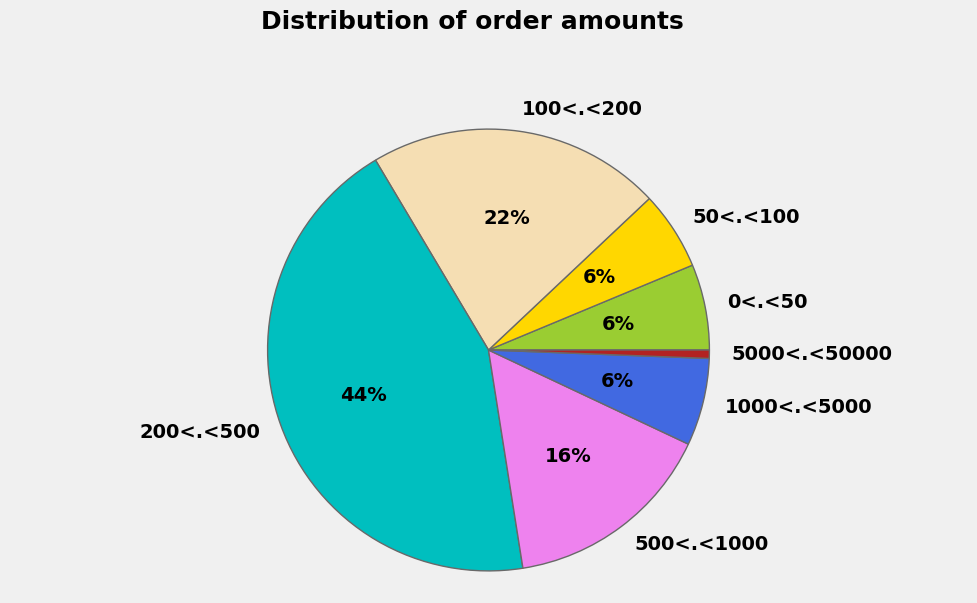

In [54]:
#____________________
# Purchase Countdown
price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
count_price = []
for i, price in enumerate(price_range):
    if i == 0: continue
    val = basketprice[(basketprice['BasketPrice'] < price) &
                       (basketprice['BasketPrice'] > price_range[i-1])]['BasketPrice'].count()
    count_price.append(val)
#____________________________________________
# Representation of number of purchases / amount        
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue','firebrick']
labels = [ '{}<.<{}'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes  = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Distribution of order amounts", ha='center', fontsize = 18);

PRODUCT CATEGORIES

Use Description variable to group the products in different categories

This function takes as input the dataframe and analyzes the content of the Description column by performing the following operations:

1. extract the names (proper, common) appearing in the products description
2. for each name, I extract the root of the word and aggregate the set of names associated with this particular root
3. count the number of times each root appears in the dataframe
4. when several words are listed for the same root, I consider that the keyword associated with this root is the shortest name (this systematically selects the singular when there are singular/plural variants)

In [55]:
df_cleaned

InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

               InvoiceDate  UnitPrice CustomerID         Country  \
0      2010-12-01 08:26:00       2.55      17850  United Kingdom   
1      2010-12-01 08:26:00       3.39      17850  United Kingdom   
2      2010-12-01 08:26:00       2.75      17850  United Kingdom   
3      2010-12-01 08:26:00       3.39      17850  United Kingdom   
4      2010-12-01 08:26:00       3.39      17850  United Kingdom   
...                    ...        ...        ...             ...   
541904 2011-12-09 12:50:00       0.85      12680          France   
541905 2011-12-09 12:50:00       2.10      12680          France   
541906 2011-12-09 12:50:00       4.15      12680          France   
541907 2011-12-09 12:50:00       4.15      12680          France   
541908 2011-12-09 12:50:00       4.95      12680          France   

        QuantityCancelled  TotalPrice  
0                       0       15.30  
1                       0       20.34  
2                       0       22.00  
3                       0       20.34  
4                       0       20.34  
...                   ...         ...  
541904                  0       10.20  
541905                  0       12.60  
541906                  0       16.60  
541907                  0       16.60  
541908                  0       14.85  

[392857 rows x 10 columns]

In [56]:
is_noun = lambda pos: pos[:2] == 'NN'

def keywords_inventory(dataframe, colonne = 'Description'):
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots  = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys   = []
    count_keywords  = dict()
    icount = 0
    for s in dataframe[colonne]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
        
        for t in nouns:
            t = t.lower() ; racine = stemmer.stem(t)
            if racine in keywords_roots:                
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1                
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)            
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
                   
    print("No. of keywords in variable '{}': {}".format(colonne,len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

In [57]:
df_products = pd.DataFrame(df_initial['Description'].unique()).rename(columns = {0:'Description'})
df_products

Description
0      WHITE HANGING HEART T-LIGHT HOLDER
1                     WHITE METAL LANTERN
2          CREAM CUPID HEARTS COAT HANGER
3     KNITTED UNION FLAG HOT WATER BOTTLE
4          RED WOOLLY HOTTIE WHITE HEART.
...                                   ...
3891            LETTER "W" BLING KEY RING
3892            LETTER "Z" BLING KEY RING
3893       PINK CRYSTAL SKULL PHONE CHARM
3894   CREAM HANGING HEART T-LIGHT HOLDER
3895          PAPER CRAFT , LITTLE BIRDIE

[3896 rows x 1 columns]

In [58]:
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_products)

No. of keywords in variable 'Description': 1483


In [59]:
print(f'Keywords: {keywords}')
print(f'keywords_roots: {keywords_roots}')
print(f'keywords_select: {keywords_select}')
print(f'count_keywords: {count_keywords}')

Keywords: ['heart', 'holder', 'metal', 'lantern', 'cream', 'cupid', 'coat', 'hanger', 'union', 'flag', 'water', 'bottle', 'nest', 'box', 'glass', 'star', 'hand', 'jack', 'warmer', 'dot', 'bird', 'ornament', 'poppy', 'playhouse', 'bedroom', 'kitchen', 'feltcraft', 'princess', 'charlotte', 'doll', 'ivory', 'cosy', 'colour', 'teaspoons', 'vintage', 'jigsaw', 'block', 'alphabet', 'home', 'building', 'word', 'love', 'recipe', 'england', 'jam', 'jar', 'rack', 'paris', 'fashion', 'bath', 'alarm', 'clock', 'bakelike', 'pink', 'green', 'panda', 'bunny', 'sheet', 'tape', 'globe', 'head', 'tail', 'game', 'set/2', 'retrospot', 'tea', 'towel', 'round', 'snack', 'woodland', 'spaceboy', 'lunch', 'i', 'london', 'circus', 'bag', 'design', 'toadstool', 'night', 'light', 'seaside', 'puzzles', 'mini', 'parade', 'paint', 'postage', 'paper', 'chain', 'christmas', 'parasol', 'coffee', 'mug', 'planet', 'billboard', 'love/hate', 'wood', 'drawer', 'cabinet', 'finish', 's/3', 'picture', 'frame', 'wooden', 'sympa

In [60]:
list_products = []
for k,v in count_keywords.items():
    list_products.append([keywords_select[k],v])
list_products.sort(key = lambda x:x[1], reverse = True)
list_products

[['heart', 267],
 ['vintage', 211],
 ['set', 206],
 ['pink', 189],
 ['bag', 165],
 ['box', 155],
 ['glass', 149],
 ['christmas', 137],
 ['design', 128],
 ['candle', 121],
 ['holder', 120],
 ['flower', 120],
 ['decorative', 109],
 ['metal', 99],
 ['retrospot', 90],
 ['card', 90],
 ['necklac', 85],
 ['paper', 84],
 ['blue', 80],
 ['art', 75],
 ['silver', 72],
 ['cake', 70],
 ['polkadot', 68],
 ['cover', 68],
 ['mug', 66],
 ['tin', 66],
 ['wrap', 65],
 ['sign', 64],
 ['pack', 61],
 ['egg', 61],
 ['bracelet', 61],
 ['star', 59],
 ['bowl', 57],
 ['mini', 56],
 ['tea', 55],
 ['garden', 55],
 ['wall', 55],
 ['ivory', 54],
 ['cushion', 54],
 ['frame', 52],
 ['mirror', 50],
 ['cream', 49],
 ['home', 49],
 ['gift', 49],
 ['earrings', 49],
 ['ring', 46],
 ['bird', 45],
 ['bottle', 44],
 ['clock', 44],
 ['paisley', 42],
 ['letter', 42],
 ['party', 42],
 ['charm', 41],
 ['wood', 40],
 ['ribbon', 40],
 ['jar', 39],
 ['garland', 39],
 ['hook', 39],
 ['gold', 39],
 ['easter', 39],
 ['bead', 38],
 ['dr

In [61]:
len(list_products)

1483

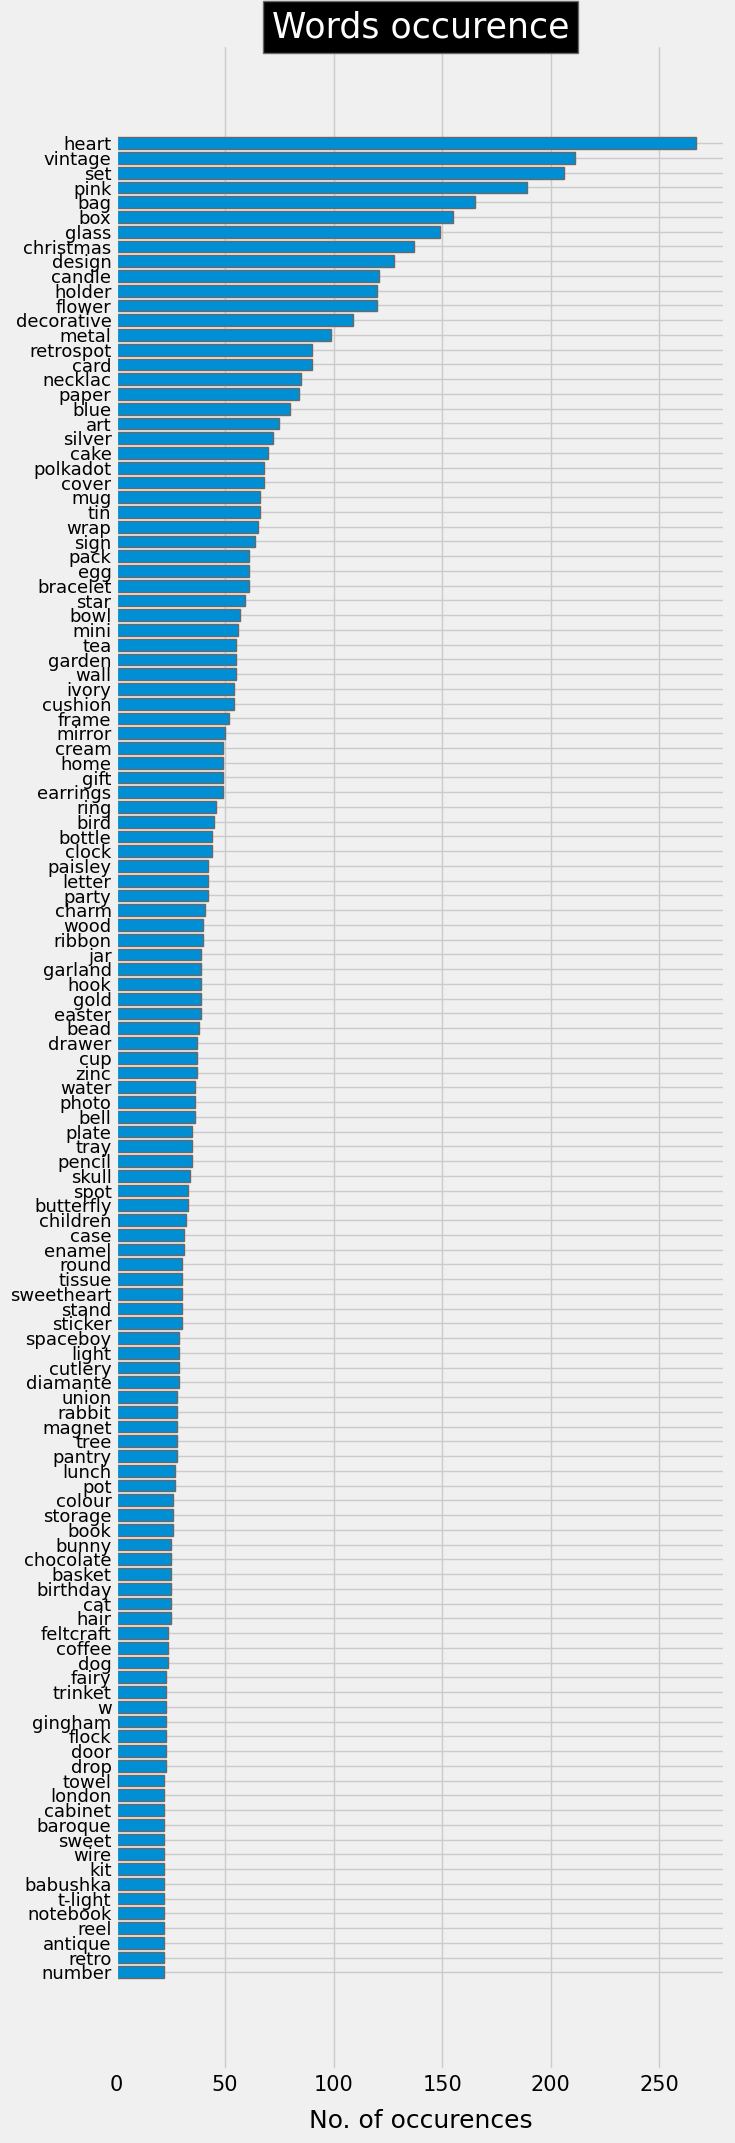

In [62]:
plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 25))
y_axis = [i[1] for i in list_products[:125]]
x_axis = [k for k,i in enumerate(list_products[:125])]
x_label = [i[0] for i in list_products[:125]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel("No. of occurences", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()

plt.title("Words occurence",bbox={'facecolor':'k', 'pad':5}, color='w',fontsize = 25)
plt.show()

The list that was obtained contains more than 1400 keywords and the most frequent ones appear in more than 200 products. However, while examinating the content of the list, I note that some names are useless. Others are do not carry information, like colors. Therefore, I discard these words from the analysis that follows and also, I decide to consider only the words that appear more than 13 times.

In [63]:
list_products = []
for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word) < 3 or v < 13: continue
    if ('+' in word) or ('/' in word): continue
    list_products.append([word, v])
#______________________________________________________    
list_products.sort(key = lambda x:x[1], reverse = True)
print('Words preserved:', len(list_products))

Words preserved: 193


DATA ENCODING

We will use these keywords to create groups of product. Define the matrix X as given below:
where the  ai,j
  coefficient is 1 if the description of the product  i
  contains the word  j
 , and 0 otherwise

In [64]:
original_description = df_cleaned['Description'].unique()
original_description

array(['WHITE HANGING HEART T-LIGHT HOLDER', 'WHITE METAL LANTERN',
       'CREAM CUPID HEARTS COAT HANGER', ...,
       'PINK CRYSTAL SKULL PHONE CHARM',
       'CREAM HANGING HEART T-LIGHT HOLDER',
       'PAPER CRAFT , LITTLE BIRDIE'], dtype=object)

In [65]:
original_description = df_cleaned['Description'].unique()
X = pd.DataFrame()
for key, occurence in list_products:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), original_description))

The  X matrix indicates the words contained in the description of the products using the one-hot-encoding principle. In practice, I have found that introducing the price range results in more balanced groups in terms of element numbers. Hence, I add 6 extra columns to this matrix, where I indicate the price range of the products:

In [66]:
# original_description

In [67]:
# df_cleaned

In [68]:
threshold = [0, 1, 2, 3, 5, 10]
label_col = []
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    label_col.append(col)
    X.loc[:, col] = 0
for i, prod in enumerate(original_description):
    prix = df_cleaned[ df_cleaned['Description'] == prod] ['UnitPrice'].mean()
    j = 0
    while prix > threshold[j]:
        j+=1
        if j == len(threshold): break
    X.loc[i, label_col[j-1]] = 1

In [69]:
print("Range     No. of Products")
print(20 * '-')
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>' + str(threshold[i])
        print(f"{col:<10}  {X[col].sum():<20}")
    else:
        col = f"{threshold[i]}<.<{threshold[i+1]}"   
        print(f"{col:<10}  {X[col].sum():<20}")

Range     No. of Products
--------------------
0<.<1       964                 
1<.<2       1009                
2<.<3       673                 
3<.<5       606                 
5<.<10      470                 
.>10        156                 


In [70]:
from kmodes.kmodes import KModes

In [71]:
X

heart  vintage  set  bag  box  glass  christmas  design  candle  holder  \
0         1        0    0    0    0      0          0       0       0       1   
1         0        0    0    0    0      0          0       0       0       0   
2         1        0    0    0    0      0          0       0       0       0   
3         0        0    0    0    0      0          0       0       0       0   
4         1        0    0    0    0      0          0       0       0       0   
...     ...      ...  ...  ...  ...    ...        ...     ...     ...     ...   
3873      0        0    0    0    0      0          0       0       0       0   
3874      0        0    0    0    0      0          0       0       0       0   
3875      0        0    0    0    0      0          0       0       0       0   
3876      1        0    0    0    0      0          0       0       0       1   
3877      0        0    0    0    0      0          0       0       0       0   

      ...  lace  jewel  wallet  point  0<.<1  1<.<2  2<.<3  3<.<5  5<.<10  \
0     ...     0      0       0      0      0      0      1      0       0   
1     ...     0      0       0      0      0      0      0      1       0   
2     ...     0      0       0      0      0      0      0      1       0   
3     ...     0      0       0      0      0      0      0      1       0   
4     ...     0      0       0      0      0      0      0      1       0   
...   ...   ...    ...     ...    ...    ...    ...    ...    ...     ...   
3873  ...     0      0       0      0      1      0      0      0       0   
3874  ...     0      0       0      0      1      0      0      0       0   
3875  ...     0      0       0      0      1      0      0      0       0   
3876  ...     0      0       0      0      0      0      1      0       0   
3877  ...     0      0       0      0      0      0      1      0       0   

      .>10  
0        0  
1        0  
2        0  
3        0  
4        0  
...    ...  
3873     0  
3874     0  
3875     0  
3876     0  
3877     0  

[3878 rows x 199 columns]

In [72]:
matrix = np.asarray(X)

In [73]:
len(matrix.shape)

2

In [74]:
# matrix = np.asarray(X)
# for n_clusters in range(3,10):
#     kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
#     kmeans.fit(matrix)
#     clusters = kmeans.predict(matrix)
#     silhouette_avg = silhouette_score(matrix, clusters)
#     print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

In [75]:
for n_clusters in range(3,10):
    kmodes = KModes(n_clusters = n_clusters, init='Huang', n_init = 30)
    clusters_2 = kmodes.fit_predict(matrix)
    silhouette_avg_2 = silhouette_score(matrix, clusters_2)
    print(f'For n_clusters: {n_clusters}, the average Silhoutte score is: {silhouette_avg_2}')

For n_clusters: 3, the average Silhoutte score is: 0.10071681758064248
For n_clusters: 4, the average Silhoutte score is: 0.12609893747265383
For n_clusters: 5, the average Silhoutte score is: 0.14524921475098385
For n_clusters: 6, the average Silhoutte score is: 0.13047711148333965
For n_clusters: 7, the average Silhoutte score is: 0.15761865181491697
For n_clusters: 8, the average Silhoutte score is: 0.11859203627951623
For n_clusters: 9, the average Silhoutte score is: 0.11983998335069673


In [ ]:
# n_clusters = 5
# silhouette_avg = -1
# while silhouette_avg < 0.145:
#     kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
#     kmeans.fit(matrix)
#     clusters = kmeans.predict(matrix)
#     silhouette_avg = silhouette_score(matrix, clusters)
    
#     #km = kmodes.KModes(n_clusters = n_clusters, init='Huang', n_init=2, verbose=0)
#     #clusters = km.fit_predict(matrix)
#     #silhouette_avg = silhouette_score(matrix, clusters)
#     print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

In [76]:
n_clusters = 5
silhouette_avg = -1
while silhouette_avg < 0.145:
    kmodes = KModes(init='Huang', n_clusters = n_clusters, n_init=30)
    kmodes.fit(matrix)
    clusters = kmodes.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    
    #km = kmodes.KModes(n_clusters = n_clusters, init='Huang', n_init=2, verbose=0)
    #clusters = km.fit_predict(matrix)
    #silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 5 The average silhouette_score is : 0.14524921475098385


In [77]:
# from sklearn.metrics import make_scorer
# from sklearn.model_selection import GridSearchCV

# scorer = make_scorer(silhouette_score)

# # Define the parameter grid
# param_grid = {'n_clusters': range(3, 10),
#               'init': ['Huang', 'Cao'],  # Add other initialization methods if needed
#               'n_init': [30]}

# # Create KModes object
# kmodes = KModes()

# # Use GridSearchCV for hyperparameter tuning
# grid_search = GridSearchCV(kmodes, param_grid, scoring=scorer, cv=5)
# grid_search.fit(matrix)

In [78]:
len(clusters)

3878

In [79]:
pd.DataFrame(clusters).value_counts()

0    1165
1     964
2     673
3     606
4     470
Name: count, dtype: int64

In [80]:
def graph_component_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters):
    plt.rcParams["patch.force_edgecolor"] = True
    plt.style.use('fivethirtyeight')
    mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)

    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10

    for i in range(n_clusters):
        #___________________________________________________________________________________
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)        
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                           facecolor=color, edgecolor=color, alpha=0.8)
        
         #____________________________________________________________________
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'red', fontweight = 'bold',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round, pad=0.3'))
        #______________________________________
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  

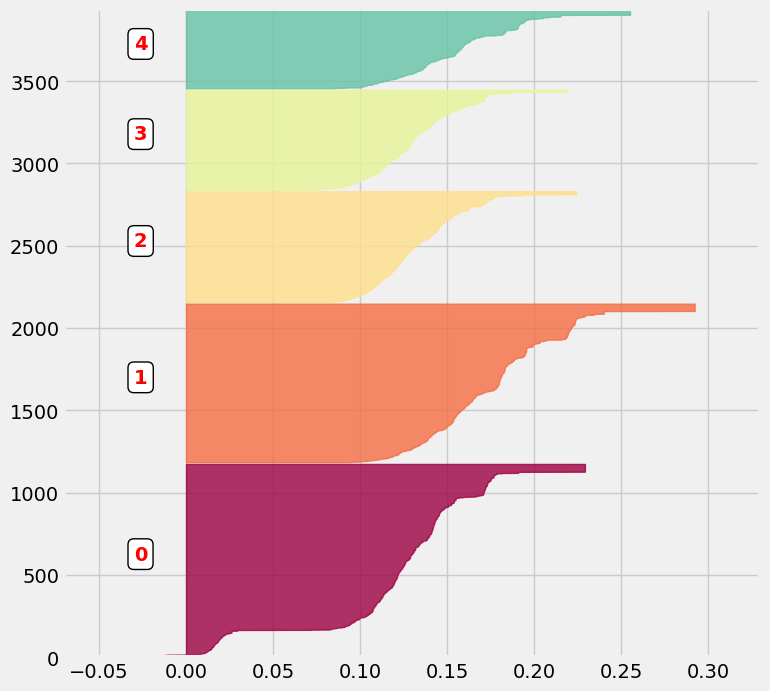

In [81]:
#____________________________________
# define individual silouhette scores
sample_silhouette_values = silhouette_samples(matrix, clusters)
#__________________
# and do the graph
graph_component_silhouette(n_clusters, [-0.07, 0.33], len(X), sample_silhouette_values, clusters)

In [82]:
# original_description

In [83]:
lists = pd.DataFrame(original_description)
lists_words = [word for (word, occurence) in list_products]

occurence = [dict() for _ in range(n_clusters)]

for i in range(n_clusters):
    list_cluster = lists.loc[clusters == i]
    for word in lists_words:
        if word in ['art', 'set', 'heart', 'pink', 'blue', 'tag']: continue
        occurence[i][word] = sum(list_cluster.loc[:, 0].str.contains(word.upper()))

In [84]:
clusters

array([2, 3, 3, ..., 1, 2, 2], dtype=uint16)

In [85]:
occurence

[{'vintage': 76,
  'bag': 61,
  'box': 44,
  'glass': 40,
  'christmas': 39,
  'design': 40,
  'candle': 55,
  'holder': 45,
  'flower': 38,
  'decorative': 8,
  'metal': 50,
  'retrospot': 23,
  'card': 9,
  'necklac': 7,
  'paper': 27,
  'silver': 18,
  'cake': 25,
  'polkadot': 20,
  'cover': 12,
  'mug': 35,
  'tin': 34,
  'wrap': 4,
  'sign': 69,
  'pack': 14,
  'egg': 29,
  'bracelet': 1,
  'star': 15,
  'bowl': 21,
  'mini': 12,
  'tea': 29,
  'garden': 33,
  'wall': 19,
  'ivory': 26,
  'cushion': 7,
  'frame': 16,
  'mirror': 30,
  'cream': 19,
  'home': 5,
  'gift': 13,
  'earrings': 1,
  'ring': 32,
  'bird': 21,
  'bottle': 4,
  'clock': 7,
  'paisley': 12,
  'letter': 5,
  'party': 16,
  'charm': 10,
  'wood': 40,
  'ribbon': 21,
  'jar': 10,
  'garland': 14,
  'hook': 15,
  'gold': 9,
  'easter': 25,
  'bead': 18,
  'drawer': 28,
  'cup': 22,
  'zinc': 14,
  'water': 4,
  'photo': 10,
  'bell': 15,
  'plate': 17,
  'tray': 10,
  'pencil': 10,
  'skull': 12,
  'spot': 36,


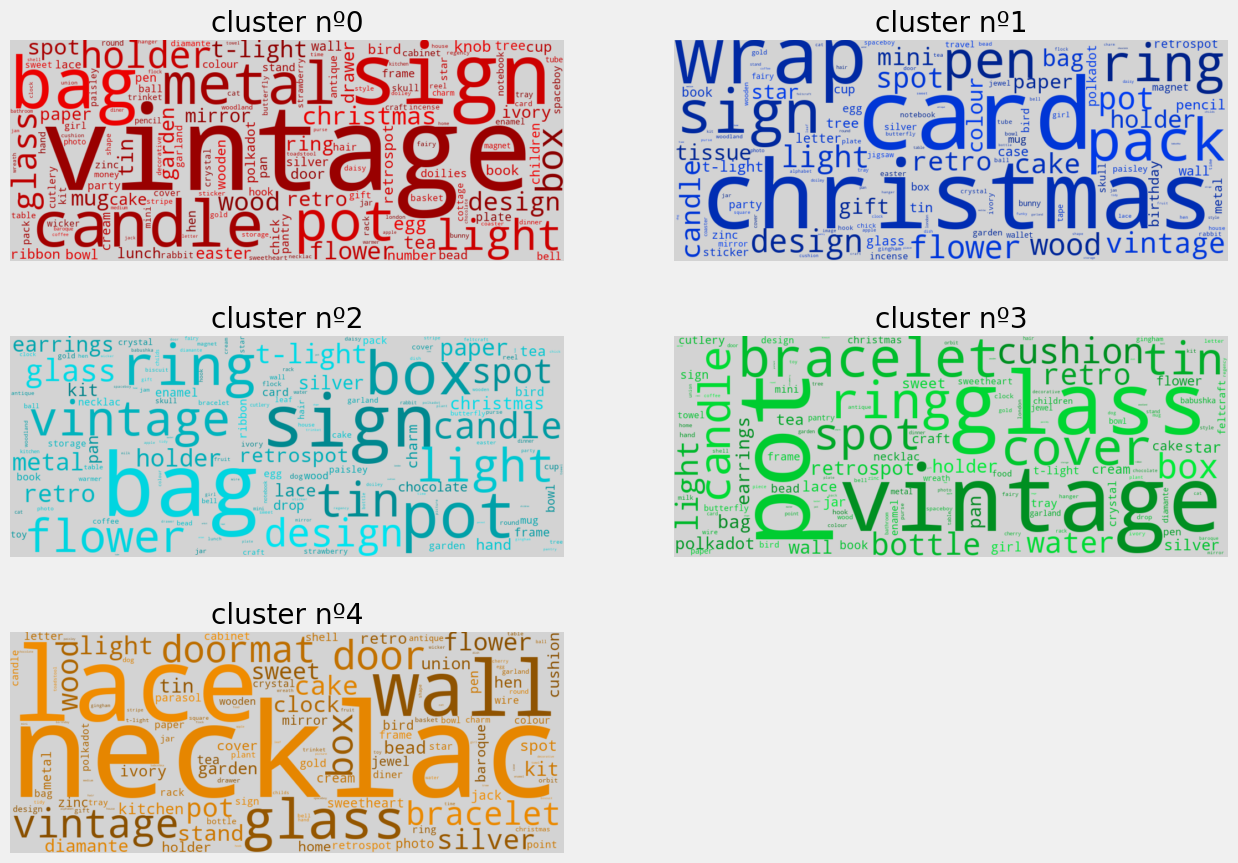

In [86]:
#________________________________________________________________________
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)
#________________________________________________________________________
def make_wordcloud(lists, increment):
    ax1 = fig.add_subplot(4,2,increment)
    words = dict()
    trunc_occurences = lists[0:150]
    for s in trunc_occurences:
        words[s[0]] = s[1]
    #________________________________________________________
    wordcloud = WordCloud(width=1000,height=400, background_color='lightgrey', 
                          max_words=1628,relative_scaling=1,
                          color_func = random_color_func,
                          normalize_plurals=False)
    wordcloud.generate_from_frequencies(words)
    ax1.imshow(wordcloud, interpolation="bilinear")
    ax1.axis('off')
    plt.title('cluster nº{}'.format(increment-1))
#________________________________________________________________________
fig = plt.figure(1, figsize=(14,14))
color = [0, 160, 130, 95, 280, 40, 330, 110, 25]
for i in range(n_clusters):
    list_cluster_occurences = occurence[i]

    tone = color[i] # define the color of the words
    liste = []
    for key, value in list_cluster_occurences.items():
        liste.append([key, value])
    liste.sort(key = lambda x:x[1], reverse = True)
    make_wordcloud(liste, i+1)

In order to ensure that these clusters are truly distinct, I look at their composition. Given the large number of variables of the initial matrix, I first perform a PCA:

In [87]:
pca = PCA()
pca.fit(matrix)
pca_samples = pca.transform(matrix)

In [88]:
pca_samples

array([[ 4.04146662e-02,  4.97230972e-01,  8.86108601e-02, ...,
         3.53393613e-04, -2.11123394e-03,  1.94657968e-15],
       [-1.82800408e-02,  4.22521729e-01,  5.60009834e-01, ...,
         3.28279183e-04, -1.73540170e-03,  4.35565310e-16],
       [ 1.56363862e-02,  3.15742200e-01,  1.24744354e+00, ...,
        -2.89423998e-03,  2.12892191e-03,  1.50591901e-15],
       ...,
       [-7.00204037e-01, -4.33656636e-01, -1.21753185e-01, ...,
         1.23958283e-03,  7.00072063e-03, -5.29866667e-16],
       [ 4.64950132e-02,  5.08854136e-01,  1.11871933e-01, ...,
         4.64582303e-03,  4.59710854e-05,  1.43455898e-15],
       [-3.63126969e-02,  6.33805390e-01, -6.04740504e-01, ...,
         9.91835682e-05, -9.88603744e-04,  8.76273704e-16]])

In [89]:
exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

In [90]:
cum_sum_eigenvalues

array([0.07585703, 0.13777759, 0.18765559, 0.23517175, 0.27589073,
       0.30914254, 0.33475232, 0.35820495, 0.37984506, 0.39705912,
       0.41207999, 0.42646856, 0.44037285, 0.45387407, 0.46672722,
       0.47901995, 0.49093712, 0.50244958, 0.51306252, 0.52336193,
       0.53359633, 0.54344274, 0.55258352, 0.56108861, 0.56937013,
       0.57747233, 0.58513521, 0.59271013, 0.60004631, 0.60713727,
       0.61401909, 0.62073128, 0.6272189 , 0.6335801 , 0.63980408,
       0.64598477, 0.65195728, 0.65782025, 0.66355617, 0.66927314,
       0.67481311, 0.68029011, 0.68566025, 0.6910008 , 0.69623275,
       0.70137156, 0.7063882 , 0.7112878 , 0.71613134, 0.72085641,
       0.72555392, 0.73006699, 0.7344239 , 0.73870542, 0.74293634,
       0.74715687, 0.75135691, 0.75545896, 0.75945591, 0.76338536,
       0.76721244, 0.77096751, 0.77461095, 0.77818906, 0.78172069,
       0.78519567, 0.78863468, 0.79204827, 0.79537625, 0.79868871,
       0.80192836, 0.80511946, 0.80827391, 0.81137976, 0.81446

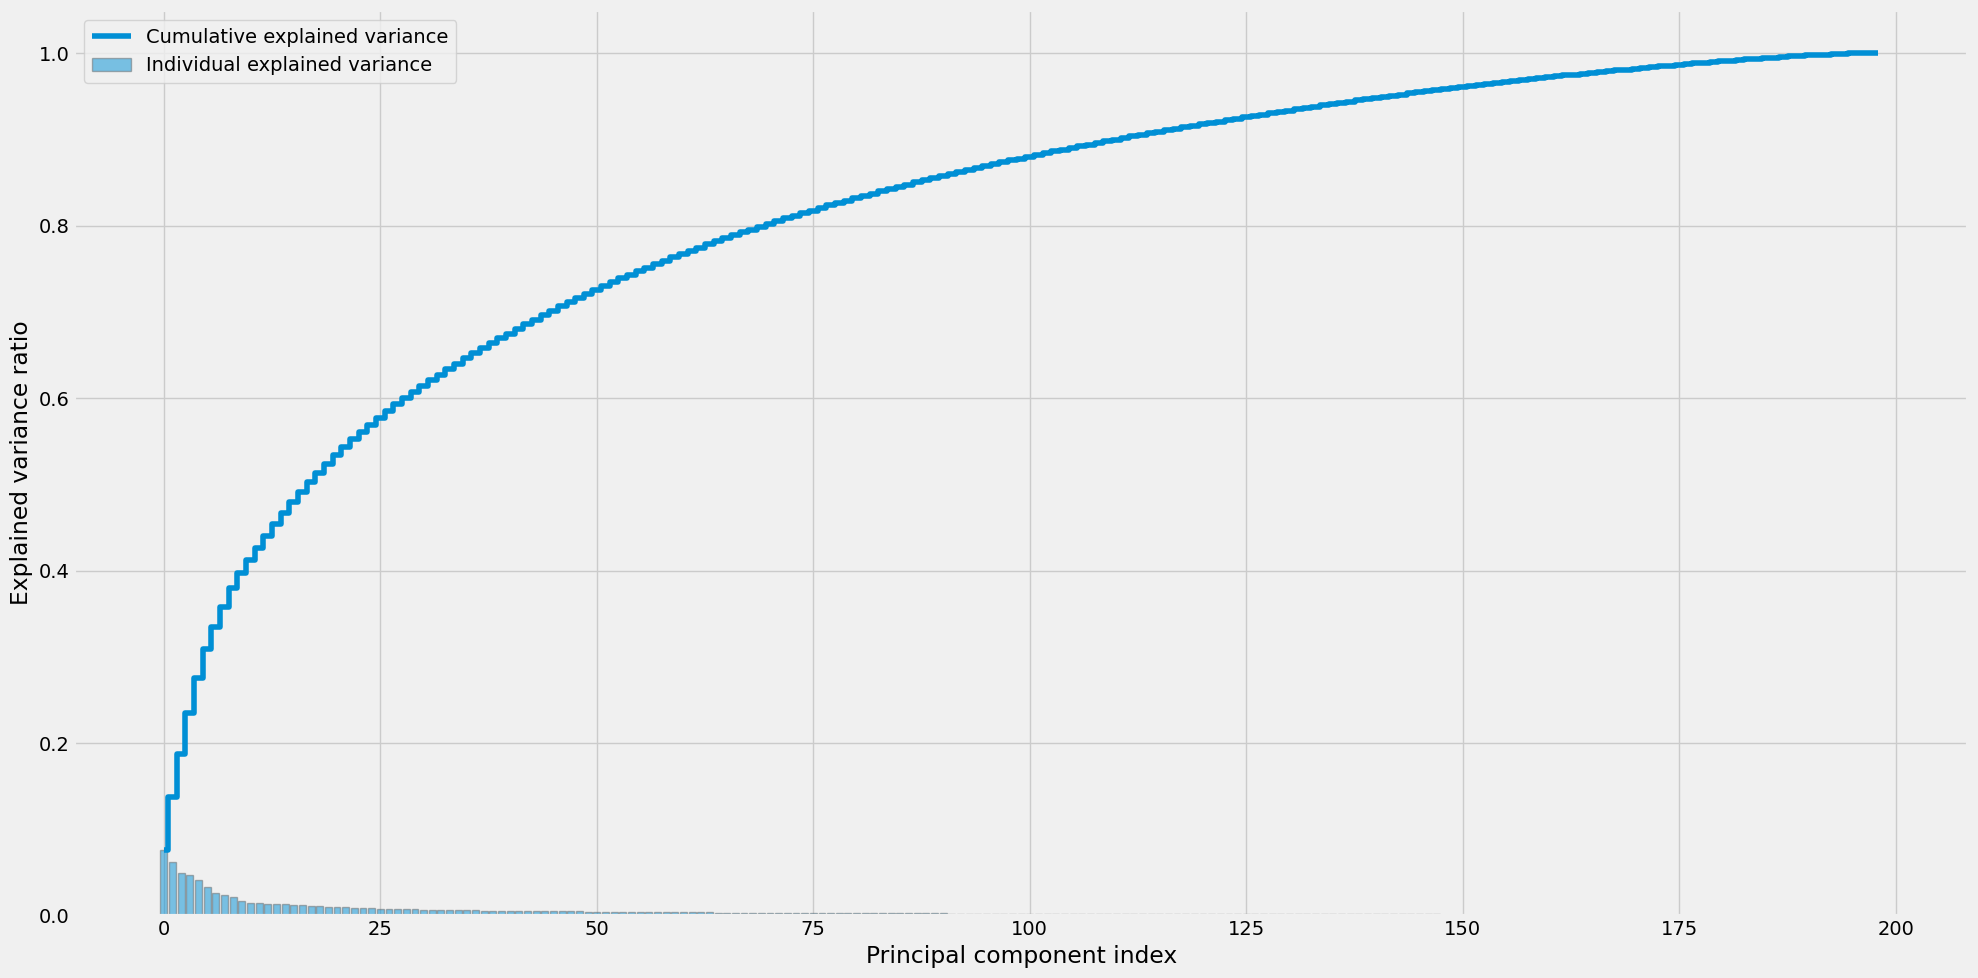

In [91]:
plt.subplots(figsize=(20,10))
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [92]:
pca = PCA(n_components=50)
pca.fit(matrix)
mattrix_9D = pca.transform(matrix)
mat = pd.DataFrame(mattrix_9D)
mat['cluster'] = pd.Series(clusters)

In [93]:
mat

0         1         2         3         4         5         6  \
0     0.040415  0.497231  0.088611  1.585314 -0.341039 -0.165409  0.682014   
1    -0.018280  0.422522  0.560010 -0.433862 -0.344757 -0.180222 -0.252114   
2     0.015636  0.315742  1.247443  0.749119 -0.505764 -0.011953 -0.163501   
3    -0.035557  0.467759  0.633836 -0.475280 -0.348023 -0.157522 -0.188438   
4     0.008751  0.319166  1.232739  0.739152 -0.492979 -0.010325 -0.144188   
...        ...       ...       ...       ...       ...       ...       ...   
3873 -0.728052 -0.428815 -0.118996 -0.108652 -0.051229 -0.111368 -0.098356   
3874 -0.728052 -0.428815 -0.118996 -0.108652 -0.051229 -0.111368 -0.098356   
3875 -0.700204 -0.433657 -0.121753 -0.080155 -0.025288 -0.079466 -0.050175   
3876  0.046495  0.508854  0.111871  1.599999 -0.339994 -0.166184  0.670402   
3877 -0.036313  0.633805 -0.604740  0.237360 -0.136723 -0.140074  0.003492   

             7         8         9  ...        41        42        43  \
0     1.027690  0.750725  0.222334  ...  0.008760 -0.023295  0.017392   
1    -0.004568  0.149668 -0.088487  ...  0.007723 -0.013334  0.008100   
2    -0.125192 -0.027653 -0.015310  ... -0.147935 -0.092251 -0.071138   
3     0.065892 -0.049793 -0.041587  ... -0.155855 -0.319599 -0.249506   
4    -0.115458 -0.008464  0.004302  ... -0.010924 -0.075262  0.030935   
...        ...       ...       ...  ...       ...       ...       ...   
3873  0.094804 -0.197297 -0.217499  ... -0.153255  0.046123 -0.060793   
3874  0.094804 -0.197297 -0.217499  ... -0.153255  0.046123 -0.060793   
3875  0.034440 -0.092797 -0.054054  ...  0.513327 -0.074017  0.025301   
3876  1.026303  0.741821  0.236712  ... -0.055283  0.060565  0.004032   
3877  0.044477 -0.148840 -0.086684  ...  0.109006  0.262694 -0.173061   

            44        45        46        47        48        49  cluster  
0    -0.140324  0.044940 -0.073557 -0.005242 -0.045602 -0.048096        2  
1     0.000056 -0.020085 -0.010472 -0.062392  0.061235 -0.038616        3  
2    -0.395651 -0.037498 -0.150430  0.034898 -0.135864 -0.006058        3  
3     0.149304  0.963821  0.119853 -0.188570 -0.471245  0.043182        3  
4    -0.044166 -0.015127 -0.108379 -0.002325  0.036454 -0.016727        3  
...        ...       ...       ...       ...       ...       ...      ...  
3873  0.078607  0.098405  0.074098  0.037190  0.049509 -0.115999        1  
3874  0.078607  0.098405  0.074098  0.037190  0.049509 -0.115999        1  
3875 -0.138884 -0.081595  0.223266 -0.011492 -0.072614  0.228093        1  
3876 -0.219956  0.137090 -0.106305  0.105701  0.036382  0.013254        2  
3877 -0.059049 -0.129682  0.158369  0.232250  0.322048  0.164623        2  

[3878 rows x 51 columns]

In [94]:
import matplotlib.patches as mpatches
sns.set_style("white")
sns.set_context("notebook", font_scale = 1, rc={"lines.linewidth" : 2.5})

label_color_map = {0: 'r', 1: 'gold', 2: 'b', 3: 'k', 4: 'c', 5: 'g'  }
label_color = [label_color_map[l] for l in mat['cluster']]

def pca_visualise(pca_comp):
    fig = plt.figure( figsize = (15,8))
    increment = 0
    for ix in range(pca_comp):
        for iy in range(ix+1, pca_comp):
            increment += 1
            ax = fig.add_subplot(2,3,increment)
            ax.scatter(mat[ix], mat[iy], c=label_color, alpha=0.4)
            plt.ylabel(ylabel = f'PCA {iy+1}', fontsize = 12) 
            plt.xlabel(xlabel = f'PCA {ix+1}', fontsize = 12) 
            ax.yaxis.grid(color = 'lightgray', linestyle = ':')
            ax.xaxis.grid(color = 'lightgray', linestyle = ':')
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)

            if increment == 9: break
        if increment == 9: break

    comp_handler = []
    for i in range(5):
        comp_handler.append(mpatches.Patch(color = label_color_map[i], label = i))

    plt.legend(handles = comp_handler, bbox_to_anchor = (1.1, 0.97), title='Cluster', facecolor='lightgrey',
            shadow=True, frameon='lightgrey', framealpha=1, fontsize=13,
            bbox_transform=plt.gcf().transFigure)

    plt.show()

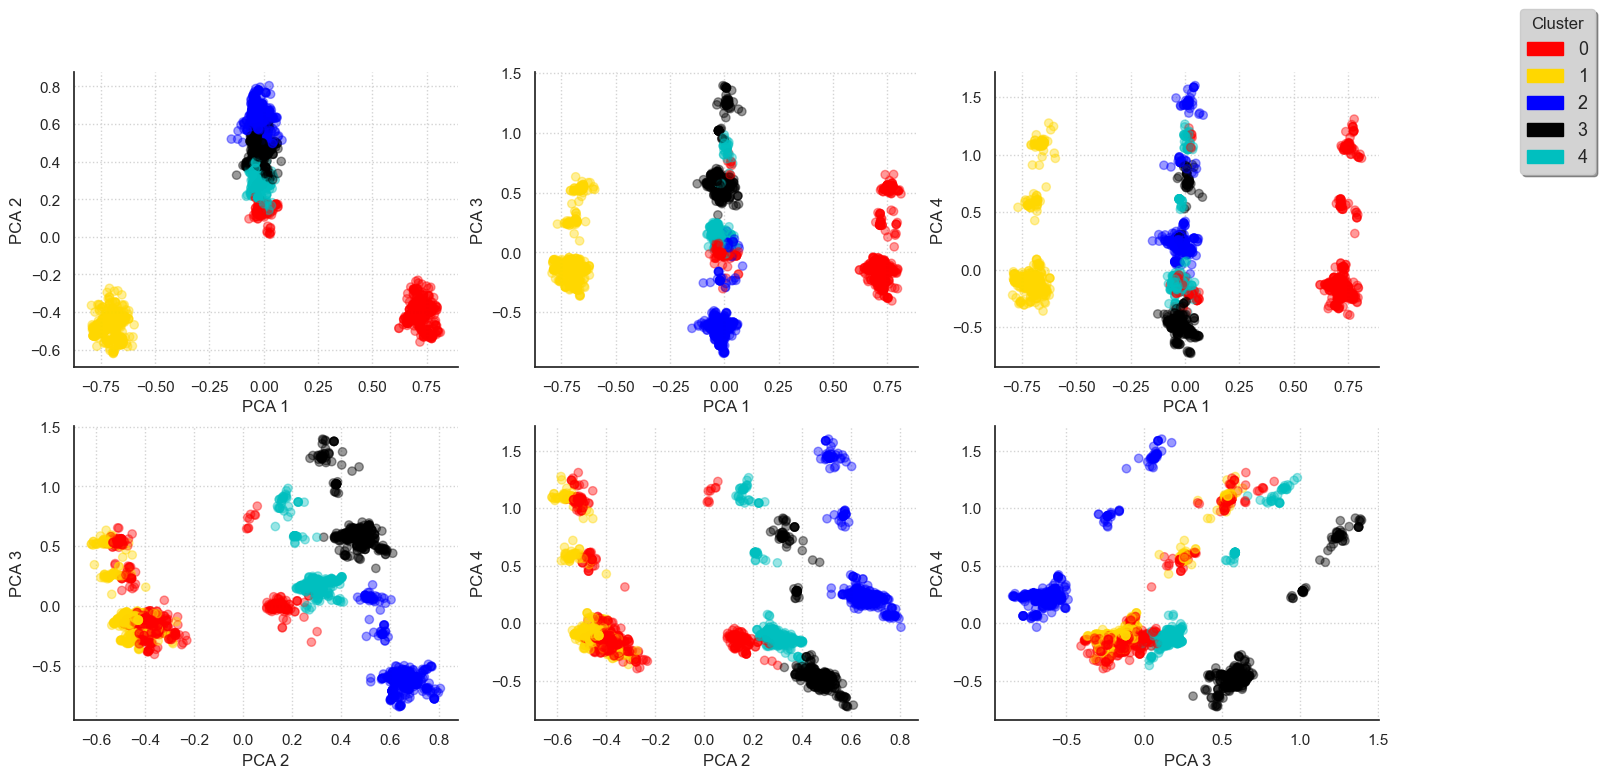

In [95]:
pca_visualise(4)

create the categorical variable categ_product which indicate the cluster of each product

In [96]:
corresp = dict()
for key, val in zip(original_description, clusters):
    corresp[key] = val

df_cleaned['categ_product'] = df_cleaned.loc[:, 'Description'].map(corresp)

Grouping Products

In [97]:
for i in range(5):
    col = f'categ_{i}'        
    df_temp = df_cleaned[df_cleaned['categ_product'] == i]
    price_temp = df_temp['UnitPrice'] * (df_temp['Quantity'] - df_temp['QuantityCancelled'])
    price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
    df_cleaned.loc[:, col] = price_temp
    df_cleaned[col].fillna(0, inplace = True)
#__________________________________________________________________________________________________
df_cleaned[['InvoiceNo', 'Description', 'categ_product', 'categ_0', 'categ_1', 'categ_2', 'categ_3','categ_4']][:5]

InvoiceNo                          Description  categ_product  categ_0  \
0    536365   WHITE HANGING HEART T-LIGHT HOLDER              2      0.0   
1    536365                  WHITE METAL LANTERN              3      0.0   
2    536365       CREAM CUPID HEARTS COAT HANGER              3      0.0   
3    536365  KNITTED UNION FLAG HOT WATER BOTTLE              3      0.0   
4    536365       RED WOOLLY HOTTIE WHITE HEART.              3      0.0   

   categ_1  categ_2  categ_3  categ_4  
0      0.0     15.3     0.00      0.0  
1      0.0      0.0    20.34      0.0  
2      0.0      0.0    22.00      0.0  
3      0.0      0.0    20.34      0.0  
4      0.0      0.0    20.34      0.0

create a new dataframe that contains, for each order, the amount of the basket, as well as the way it is distributed over the 5 categories of products

In [98]:
df_cleaned

InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

               InvoiceDate  UnitPrice CustomerID         Country  \
0      2010-12-01 08:26:00       2.55      17850  United Kingdom   
1      2010-12-01 08:26:00       3.39      17850  United Kingdom   
2      2010-12-01 08:26:00       2.75      17850  United Kingdom   
3      2010-12-01 08:26:00       3.39      17850  United Kingdom   
4      2010-12-01 08:26:00       3.39      17850  United Kingdom   
...                    ...        ...        ...             ...   
541904 2011-12-09 12:50:00       0.85      12680          France   
541905 2011-12-09 12:50:00       2.10      12680          France   
541906 2011-12-09 12:50:00       4.15      12680          France   
541907 2011-12-09 12:50:00       4.15      12680          France   
541908 2011-12-09 12:50:00       4.95      12680          France   

        QuantityCancelled  TotalPrice  categ_product  categ_0  categ_1  \
0                       0       15.30              2      0.0      0.0   
1                       0       20.34              3      0.0      0.0   
2                       0       22.00              3      0.0      0.0   
3                       0       20.34              3      0.0      0.0   
4                       0       20.34              3      0.0      0.0   
...                   ...         ...            ...      ...      ...   
541904                  0       10.20              1      0.0     10.2   
541905                  0       12.60              2      0.0      0.0   
541906                  0       16.60              3      0.0      0.0   
541907                  0       16.60              3      0.0      0.0   
541908                  0       14.85              3      0.0      0.0   

        categ_2  categ_3  categ_4  
0          15.3     0.00      0.0  
1           0.0    20.34      0.0  
2           0.0    22.00      0.0  
3           0.0    20.34      0.0  
4           0.0    20.34      0.0  
...         ...      ...      ...  
541904      0.0     0.00      0.0  
541905     12.6     0.00      0.0  
541906      0.0    16.60      0.0  
541907      0.0    16.60      0.0  
541908      0.0    14.85      0.0  

[392857 rows x 16 columns]

In [99]:
df_cleaned.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'QuantityCancelled', 'TotalPrice',
       'categ_product', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4'],
      dtype='object')

In [100]:
#sum of purchases 
temp = df_cleaned.groupby(by = ['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice' : 'Basket Price'})

#percentage of order price 
for i in range(5):
    col = f'categ_{i}'
    temp = df_cleaned.groupby(by = ['CustomerID', 'InvoiceNo'], as_index=False)[col].sum()
    basket_price.loc[:, col] = temp[col]

#date of the order
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')

temp = df_cleaned.groupby(by = ['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()

df_cleaned.drop('InvoiceDate_int', axis=1, inplace=True)
basket_price.loc[:, 'InvoiceDate'] = pd.DataFrame(temp['InvoiceDate_int'])

basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID', ascending = True)[:5]

CustomerID InvoiceNo  Basket Price  categ_0  categ_1  categ_2  categ_3  \
0      12346    541431       2968.60     0.00     0.00     0.00     0.00   
1      12347    537626        711.79   187.20    23.40    83.40   293.35   
2      12347    542237        475.39   168.75    84.34    53.10   169.20   
3      12347    549222        636.25   369.15    81.00    71.10   115.00   
4      12347    556201        382.52    74.40    41.40    78.06   168.76   

   categ_4   InvoiceDate  
0     0.00  1.295345e+18  
1   124.44  1.291734e+18  
2     0.00  1.296052e+18  
3     0.00  1.302173e+18  
4    19.90  1.307624e+18

In [101]:
basket_price['InvoiceDate'] = pd.to_datetime(basket_price['InvoiceDate'])
basket_price

CustomerID InvoiceNo  Basket Price  categ_0  categ_1  categ_2  categ_3  \
0          12346    541431       2968.60     0.00     0.00     0.00     0.00   
1          12347    537626        711.79   187.20    23.40    83.40   293.35   
2          12347    542237        475.39   168.75    84.34    53.10   169.20   
3          12347    549222        636.25   369.15    81.00    71.10   115.00   
4          12347    556201        382.52    74.40    41.40    78.06   168.76   
...          ...       ...           ...      ...      ...      ...      ...   
18627      18283    579673        220.31    74.70    29.65   106.21     9.75   
18628      18283    580872        208.00    61.90    27.07   119.03     0.00   
18629      18287    554065        765.28   540.90    40.68   134.70    15.00   
18630      18287    570715       1001.32   386.44   256.84   326.04    32.00   
18631      18287    573167         70.68    45.00    25.68     0.00     0.00   

       categ_4                   InvoiceDate  
0         0.00 2011-01-18 10:01:00.000000000  
1       124.44 2010-12-07 14:57:00.000000000  
2         0.00 2011-01-26 14:29:59.999999744  
3         0.00 2011-04-07 10:43:00.000000000  
4        19.90 2011-06-09 13:01:00.000000000  
...        ...                           ...  
18627     0.00 2011-11-30 12:59:00.000000000  
18628     0.00 2011-12-06 12:02:00.000000000  
18629    34.00 2011-05-22 10:39:00.000000000  
18630     0.00 2011-10-12 10:23:00.000000000  
18631     0.00 2011-10-28 09:29:00.000000000  

[18514 rows x 9 columns]

Splitting the data

In [102]:
basket_price_train = basket_price[basket_price['InvoiceDate'] < '2011-10-1']
basket_price_test = basket_price[basket_price['InvoiceDate'] >= '2011-10-1']

In [103]:
len(basket_price_train), len(basket_price_test)

(13157, 5357)

In [216]:
basket_price = basket_price_train.copy(deep=True)

Consumer Order Combinations



In a second step, I group together the different entries that correspond to the same user. I thus determine the number of purchases made by the user, as well as the minimum, maximum, average amounts and the total amount spent during all the visits:

In [128]:
transaction_per_user = basket_price_train.groupby(by=['CustomerID'], as_index=False)['Basket Price'].agg(['count', 'min',
                                                                                                    'max', 'mean', 'sum'])


for i in range(5):
    col = f'categ_{i}'
    col_1 = f'categ_new_{i}'
    temp = basket_price_train.groupby(by = ['CustomerID'], as_index = False)[col].sum()
    transaction_per_user.loc[:, col] = temp[col]
    transaction_per_user.loc[:, col_1] = transaction_per_user[col] / transaction_per_user['sum'] *100

transaction_per_user.drop(['categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4'], axis=1, inplace = True)
transaction_per_user.rename(columns={'categ_new_0' : 'categ_0', 'categ_new_1' : 'categ_1', 'categ_new_2' : 'categ_2', 'categ_new_3' : 'categ_3', 'categ_new_4' : 'categ_4'}, inplace=True)
transaction_per_user.sort_values('CustomerID', ascending = True)[:5]

CustomerID  count      min      max         mean      sum    categ_0  \
0      12346      1  2968.60  2968.60  2968.600000  2968.60   0.000000   
1      12347      5   382.52   711.79   558.172000  2790.86  33.948317   
2      12348      4   227.44   892.80   449.310000  1797.24  61.983931   
3      12350      1   334.40   334.40   334.400000   334.40  60.406699   
4      12352      7    57.33   840.30   304.472857  2131.31  64.346810   

     categ_1    categ_2    categ_3    categ_4  
0   0.000000   0.000000   0.000000   0.000000  
1  10.442659  14.524555  32.408290   8.676179  
2  38.016069   0.000000   0.000000   0.000000  
3  11.692584  27.900718   0.000000   0.000000  
4   0.478579   3.279673  15.288719  13.916324

Additional variables that give the number of days elapsed since the first purchase ( FirstPurchase ) and the number of days since the last purchase ( LastPurchase )

In [144]:
last_date = basket_price['InvoiceDate'].max().date()
first_purchase = pd.DataFrame(basket_price.groupby(by=['CustomerID'], as_index=False)['InvoiceDate'].min())
first_purchase['InvoiceDate'] = pd.to_datetime(first_purchase['InvoiceDate'])
test = first_purchase['InvoiceDate'].apply(lambda x:(last_date - x.date()).days)
test

0       325
1       367
2       358
3        18
4       310
       ... 
4333    277
4334    180
4335    126
4336    337
4337    201
Name: InvoiceDate, Length: 4338, dtype: int64

In [151]:
last_date = basket_price['InvoiceDate'].max().date()
first_purchase = pd.DataFrame(basket_price.groupby(by=['CustomerID'], as_index=False)['InvoiceDate'].min())
last_purchase = pd.DataFrame(basket_price.groupby(by=['CustomerID'], as_index=False)['InvoiceDate'].max())
test = pd.DataFrame(first_purchase['InvoiceDate'].apply(lambda x:(last_date - x.date()).days))
test2 = pd.DataFrame(last_purchase['InvoiceDate'].apply(lambda x:(last_date - x.date()).days))
transaction_per_user.loc[:, 'LastPurchase'] = test2['InvoiceDate']
transaction_per_user.loc[:, 'FirstPurchase'] = test['InvoiceDate']
transaction_per_user[:5]

CustomerID  count      min      max         mean      sum    categ_0  \
0      12346      1  2968.60  2968.60  2968.600000  2968.60   0.000000   
1      12347      5   382.52   711.79   558.172000  2790.86  33.948317   
2      12348      4   227.44   892.80   449.310000  1797.24  61.983931   
3      12350      1   334.40   334.40   334.400000   334.40  60.406699   
4      12352      7    57.33   840.30   304.472857  2131.31  64.346810   

     categ_1    categ_2    categ_3    categ_4  FirstPurchase  LastPurchase  
0   0.000000   0.000000   0.000000   0.000000            325           325  
1  10.442659  14.524555  32.408290   8.676179            367             2  
2  38.016069   0.000000   0.000000   0.000000            358            75  
3  11.692584  27.900718   0.000000   0.000000             18            18  
4   0.478579   3.279673  15.288719  13.916324            310           310

A customer category of particular interest is that of customers who make only one purchase. One of the objectives may be, for example, to target these customers in order to retain them.

In [162]:
customers_one_purchase = len(transaction_per_user[transaction_per_user['count'] == 1])/len(transaction_per_user['count'])*100
customers_one_purchase


39.961283185840706

In [165]:
n1 = len(transaction_per_user[transaction_per_user['count'] == 1])
# transaction_per_user[transaction_per_user['count'] == 1].shape[0]
n1

1445

In [166]:
n2 = len(transaction_per_user['count'])
# transaction_per_user.shape[0]
n2

3616

In [170]:
print(f'No. of customers with only one purchase: {n1}/{n2} ({customers_one_purchase : .2f} %)')

No. of customers with only one purchase: 1445/3616 ( 39.96 %)


CREATION OF CUSTOMER CATEGORIES

In [171]:
transaction_per_user.columns

Index(['CustomerID', 'count', 'min', 'max', 'mean', 'sum', 'categ_0',
       'categ_1', 'categ_2', 'categ_3', 'categ_4', 'FirstPurchase',
       'LastPurchase'],
      dtype='object')

In [175]:
list_cols = ['count', 'min', 'max', 'mean', 'sum', 'categ_0' ,'categ_1', 'categ_2', 'categ_3', 'categ_4']
selected_customers = transaction_per_user.copy(deep = True)
matrix = np.asarray(selected_customers[list_cols])
matrix

array([[1.00000000e+00, 2.96860000e+03, 2.96860000e+03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.00000000e+00, 3.82520000e+02, 7.11790000e+02, ...,
        1.45245552e+01, 3.24082899e+01, 8.67617867e+00],
       [4.00000000e+00, 2.27440000e+02, 8.92800000e+02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.00000000e+00, 9.52100000e+01, 9.52100000e+01, ...,
        1.85904842e+01, 1.41791829e+01, 0.00000000e+00],
       [1.00000000e+01, 2.50000000e+00, 1.92800000e+02, ...,
        3.49079433e+01, 8.29016498e+00, 2.24506133e+00],
       [1.00000000e+00, 7.65280000e+02, 7.65280000e+02, ...,
        1.76014008e+01, 1.96006690e+00, 4.44281831e+00]])

In [176]:
matrix_max = matrix.max()
matrix_min = matrix.min()
matrix_new = (matrix-matrix_min)/(matrix_max-matrix_min)
matrix_new

array([[4.93058622e-06, 1.46369383e-02, 1.46369383e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.46529311e-05, 1.88604784e-03, 3.50954197e-03, ...,
        7.16145715e-05, 1.59791868e-04, 4.27786470e-05],
       [1.97223449e-05, 1.12141253e-03, 4.40202738e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [4.93058622e-06, 4.69441114e-04, 4.69441114e-04, ...,
        9.16619852e-05, 6.99116836e-05, 0.00000000e+00],
       [4.93058622e-05, 1.23264656e-05, 9.50617023e-04, ...,
        1.72116624e-04, 4.08753732e-05, 1.10694684e-05],
       [4.93058622e-06, 3.77327902e-03, 3.77327902e-03, ...,
        8.67852242e-05, 9.66427887e-06, 2.19056988e-05]])

In [179]:
scaler = StandardScaler()
scaler.fit(matrix)
print(f'variables mean values: {scaler.mean_}')
scaled_matrix = scaler.transform(matrix)

variables mean values: [   3.63855088  261.02603761  572.72311477  382.54211267 1671.42567865
   32.32733391   13.90338142   20.95782854   16.14776714   15.42701167]


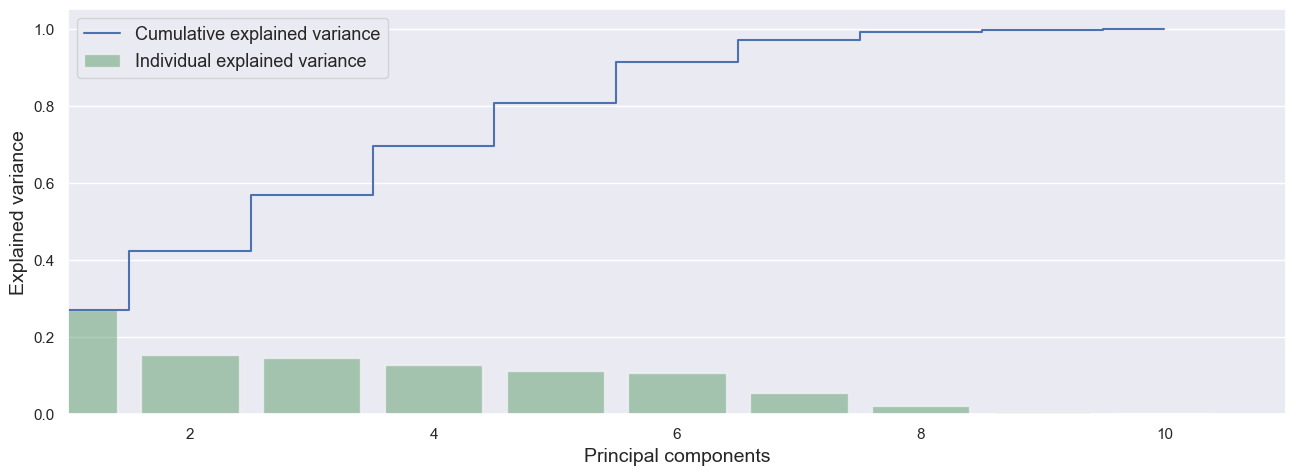

In [192]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='Cumulative explained variance')
sns.barplot(x = np.arange(1,matrix.shape[1]+1), y = pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='Individual explained variance')
plt.xlim(0, 10)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='best', fontsize = 13);

In [226]:
n_clusters=12
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
kmeans.fit(scaled_matrix)
clusters_clients = kmeans.predict(scaled_matrix)
silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
print('score de silhouette: {:<.3f}'.format(silhouette_avg))

score de silhouette: 0.212


In [239]:
pd.DataFrame(pd.Series(clusters_clients).value_counts())

count
11   1448
0     471
8     340
2     287
4     282
1     282
7     236
5     196
6      49
10     18
3       5
9       2

In [245]:
df = pd.DataFrame(pd.Series(clusters_clients).value_counts()).reset_index()
df = df.rename(columns={'index': 'cluster', 'count': 'Number of clients'})
df = df.T
df

0    1    2    3    4    5    6    7   8   9   10  11
cluster              11    0    8    2    4    1    7    5   6  10   3   9
Number of clients  1448  471  340  287  282  282  236  196  49  18   5   2

In [246]:
pca = PCA(n_components=6)
matrix_3D = pca.fit_transform(scaled_matrix)
mat = pd.DataFrame(matrix_3D)
mat['cluster'] = pd.Series(clusters_clients)

In [247]:
mat

0         1         2         3         4         5  cluster
0     6.078705  5.450756 -4.316748  0.112639  0.062496  0.632410        6
1     0.493639 -0.003367 -0.335916 -0.376584  0.326931 -1.117116       11
2     0.055870  1.630258  2.075642 -0.674516  0.899481  0.301496        0
3    -0.323808  1.431112  1.172595  0.223380 -1.078462 -0.077098        0
4    -0.016701  0.010565  1.231366 -1.681853 -0.748062 -0.556807        0
...        ...       ...       ...       ...       ...       ...      ...
3611 -0.550511 -1.483100 -1.865358  0.863858 -0.512937  0.359972        8
3612 -0.975881  1.124255  1.742151 -0.112656 -0.535075 -0.021520        0
3613 -0.919059  0.684225  1.073712  0.007348  0.030026 -0.592023        0
3614 -0.425871 -0.520156  1.411144  0.958916 -0.368436 -0.143844       11
3615  0.689385  2.352121  0.588621 -0.687031 -1.313053 -0.149825        0

[3616 rows x 7 columns]

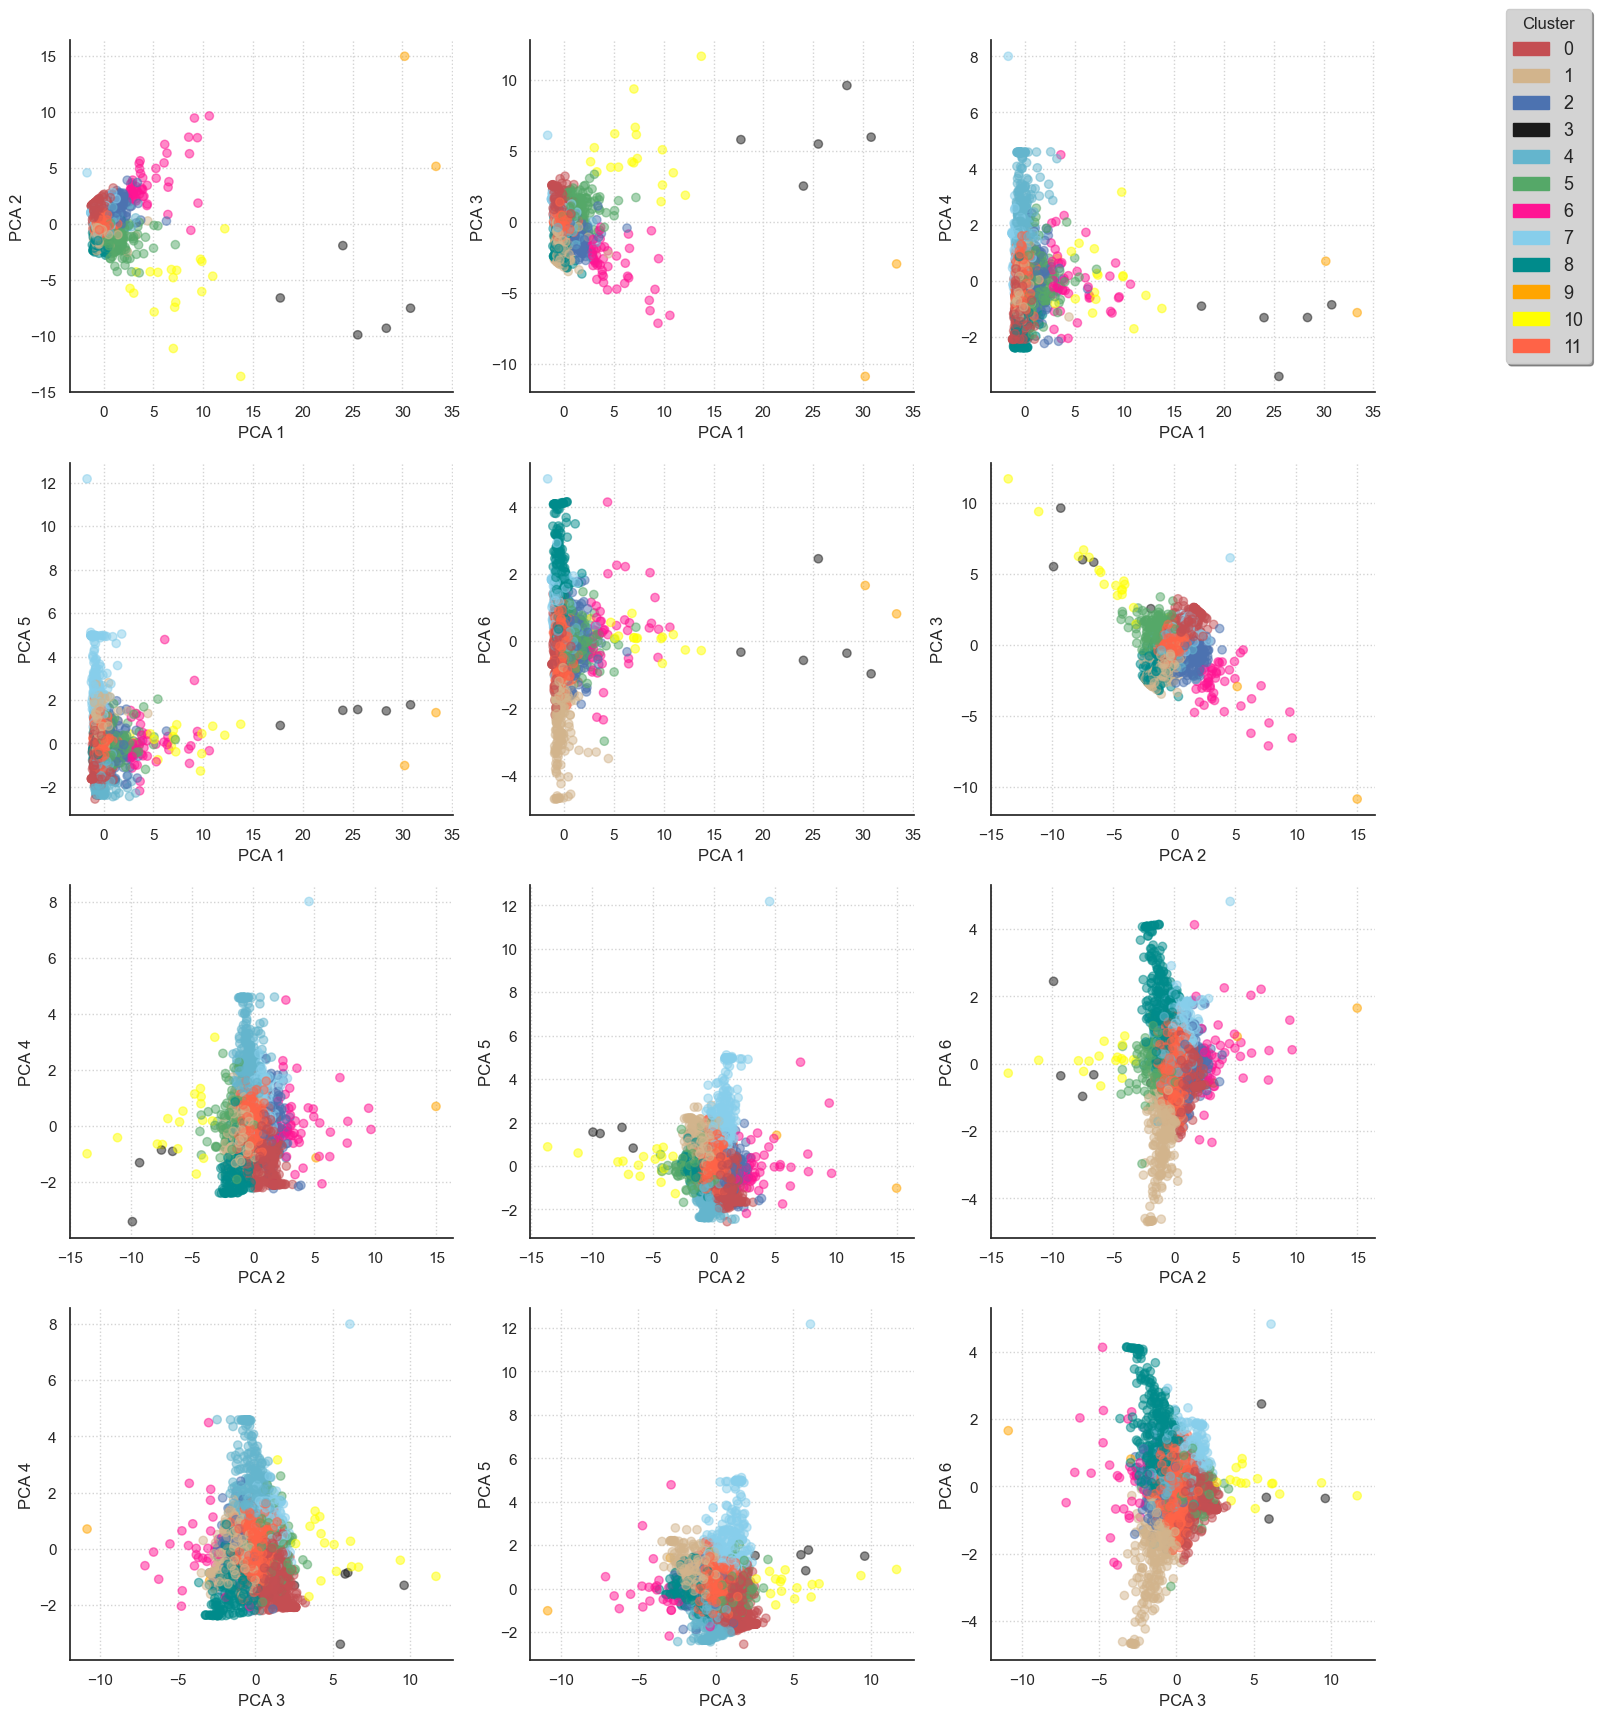

In [250]:

import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'tan', 2:'b', 3:'k', 4:'c', 5:'g', 6:'deeppink', 7:'skyblue', 8:'darkcyan', 9:'orange',
                   10:'yellow', 11:'tomato', 12:'seagreen'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (15,20))
increment = 0
for ix in range(6):
    for iy in range(ix+1, 6):   
        increment += 1
        ax = fig.add_subplot(4,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.5) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 12: break
    if increment == 12: break
        
#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(n_clusters):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.9), 
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.tight_layout()

As with product categories, another way to look at the quality of the separation is to look at silouhette scores within different clusters

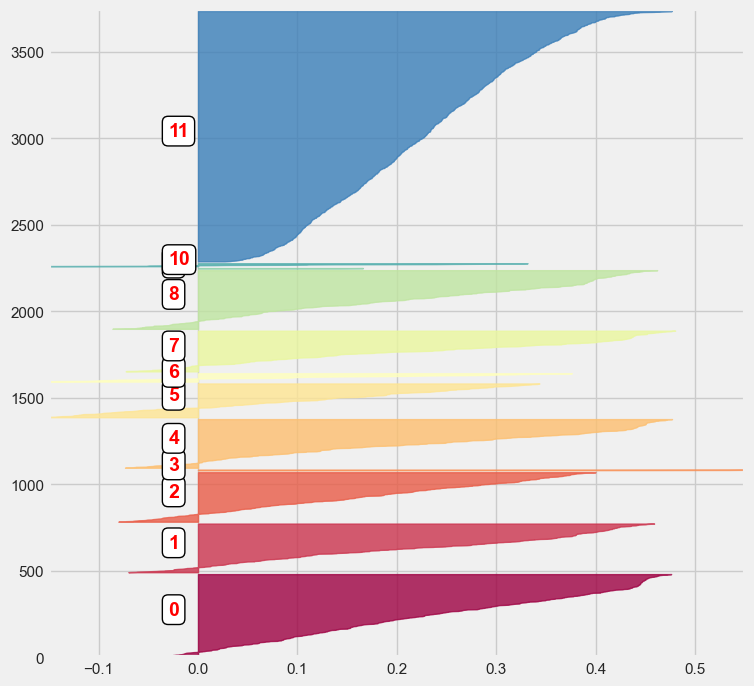

In [251]:
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)
#____________________________________
# define individual silouhette scores
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)
#__________________
# and do the graph
graph_component_silhouette(n_clusters, [-0.15, 0.55], len(scaled_matrix), sample_silhouette_values, clusters_clients)

The different clusters are indeed disjoint (at least, in a global way). It remains to understand the habits of the customers in each cluster. 

In [252]:
selected_customers

CustomerID  count      min      max         mean      sum    categ_0  \
0         12346      1  2968.60  2968.60  2968.600000  2968.60   0.000000   
1         12347      5   382.52   711.79   558.172000  2790.86  33.948317   
2         12348      4   227.44   892.80   449.310000  1797.24  61.983931   
3         12350      1   334.40   334.40   334.400000   334.40  60.406699   
4         12352      7    57.33   840.30   304.472857  2131.31  64.346810   
...         ...    ...      ...      ...          ...      ...        ...   
3611      18280      1   180.60   180.60   180.600000   180.60   0.000000   
3612      18281      1    80.82    80.82    80.820000    80.82  62.360802   
3613      18282      1    95.21    95.21    95.210000    95.21  50.887512   
3614      18283     10     2.50   192.80   108.683000  1086.83  37.352668   
3615      18287      1   765.28   765.28   765.280000   765.28  70.680013   

        categ_1    categ_2    categ_3    categ_4  FirstPurchase  LastPurchase  
0      0.000000   0.000000   0.000000   0.000000            325           325  
1     10.442659  14.524555  32.408290   8.676179            367             2  
2     38.016069   0.000000   0.000000   0.000000            358            75  
3     11.692584  27.900718   0.000000   0.000000             18            18  
4      0.478579   3.279673  15.288719  13.916324            310           310  
...         ...        ...        ...        ...            ...           ...  
3611   0.000000  41.140642  24.833887  34.025471             16             3  
3612  18.708241  18.930958   0.000000   0.000000            308           308  
3613  20.071421  18.590484  14.179183   0.000000            361             8  
3614  17.204163  34.907943   8.290165   2.245061             64            28  
3615   5.315701  17.601401   1.960067   4.442818             17            17  

[3616 rows x 13 columns]

In [253]:
selected_customers.loc[:, 'cluster'] = clusters_clients

In [254]:
selected_customers

CustomerID  count      min      max         mean      sum    categ_0  \
0         12346      1  2968.60  2968.60  2968.600000  2968.60   0.000000   
1         12347      5   382.52   711.79   558.172000  2790.86  33.948317   
2         12348      4   227.44   892.80   449.310000  1797.24  61.983931   
3         12350      1   334.40   334.40   334.400000   334.40  60.406699   
4         12352      7    57.33   840.30   304.472857  2131.31  64.346810   
...         ...    ...      ...      ...          ...      ...        ...   
3611      18280      1   180.60   180.60   180.600000   180.60   0.000000   
3612      18281      1    80.82    80.82    80.820000    80.82  62.360802   
3613      18282      1    95.21    95.21    95.210000    95.21  50.887512   
3614      18283     10     2.50   192.80   108.683000  1086.83  37.352668   
3615      18287      1   765.28   765.28   765.280000   765.28  70.680013   

        categ_1    categ_2    categ_3    categ_4  FirstPurchase  LastPurchase  \
0      0.000000   0.000000   0.000000   0.000000            325           325   
1     10.442659  14.524555  32.408290   8.676179            367             2   
2     38.016069   0.000000   0.000000   0.000000            358            75   
3     11.692584  27.900718   0.000000   0.000000             18            18   
4      0.478579   3.279673  15.288719  13.916324            310           310   
...         ...        ...        ...        ...            ...           ...   
3611   0.000000  41.140642  24.833887  34.025471             16             3   
3612  18.708241  18.930958   0.000000   0.000000            308           308   
3613  20.071421  18.590484  14.179183   0.000000            361             8   
3614  17.204163  34.907943   8.290165   2.245061             64            28   
3615   5.315701  17.601401   1.960067   4.442818             17            17   

      cluster  
0           6  
1          11  
2           0  
3           0  
4           0  
...       ...  
3611        8  
3612        0  
3613        0  
3614       11  
3615        0  

[3616 rows x 14 columns]

In [289]:
merged_df = pd.DataFrame()
for i in range(n_clusters):
    test = pd.DataFrame(selected_customers[selected_customers['cluster'] == i].mean(numeric_only = True))
    test = test.T.set_index('cluster', drop=True)
    test['size'] = selected_customers[selected_customers['cluster']==i].shape[0]
    merged_df = pd.concat([merged_df, test])

total_customers = merged_df['size'].sum()

print(f'No. of customers: {total_customers}')

No. of customers: 3616


In [290]:
merged_df = merged_df.sort_values('size')
merged_df

count          min           max          mean            sum  \
cluster                                                                      
9.0       3.000000  3732.250000  30222.950000  12779.466667   38338.400000   
3.0      35.400000    44.824000  21205.894000   4595.414962  149845.156000   
10.0     58.388889    30.499444   4947.087222    985.196251   39259.095556   
6.0       1.530612  2057.989796   2732.566122   2379.214814    3937.499184   
5.0      15.244898    92.784439   1258.986633    507.130220    6997.988265   
7.0       2.182203   191.346441    314.698432    242.911209     579.969873   
1.0       2.113475   204.665142    349.567482    269.759847     676.972340   
4.0       2.570922   208.368901    381.361560    291.235026     816.547021   
2.0       1.853659   725.818850   1028.554568    864.801340    1687.985474   
8.0       2.491176   193.294088    313.547559    247.612809     634.868765   
0.0       2.388535   193.719851    317.734800    249.304957     625.182592   
11.0      3.121547   200.068979    416.396050    300.888892     962.674193   

           categ_0    categ_1    categ_2    categ_3    categ_4  FirstPurchase  \
cluster                                                                         
9.0       9.694954   0.000000  19.088655   0.000000   6.149970     297.500000   
3.0      27.314526   8.236805  20.120099  21.898090  21.768008     181.000000   
10.0     29.907764  12.358172  30.119789  12.159391  13.550450     195.277778   
6.0      30.242059  14.590407  20.646286  16.631344  15.246881     229.857143   
5.0      31.273932  11.801619  23.736288  16.485509  15.648839     234.214286   
7.0      21.456111  57.746814  10.744558   5.975109   5.021345     222.033898   
1.0      16.505589   6.456458  14.113343  51.205010  10.620659     221.414894   
4.0      17.290715   6.990137  61.181711   6.741719   7.170064     224.099291   
2.0      36.064645  12.664211  20.885686  15.877316  13.519924     216.627178   
8.0      17.069851   5.323630  11.516428  12.820792  51.794089     235.061765   
0.0      66.625201   8.757749  10.580782   6.194808   6.826730     221.498938   
11.0     32.086198  13.807457  21.254383  16.872344  14.293603     219.330110   

         LastPurchase  size  
cluster                      
9.0         29.500000     2  
3.0         78.600000     5  
10.0        98.444444    18  
6.0         96.877551    49  
5.0         92.000000   196  
7.0         98.432203   236  
1.0         88.680851   282  
4.0         90.755319   282  
2.0         76.592334   287  
8.0         96.608824   340  
0.0         89.747346   471  
11.0        93.161602  1448

In [291]:

merged_df.index.values

array([ 9.,  3., 10.,  6.,  5.,  7.,  1.,  4.,  2.,  8.,  0., 11.])

In [292]:
list_index = []
for i in range(5):
    column = f'categ_{i}'
    list_index.append(merged_df[merged_df[column] > 45].index.values[0])
list_index_reordered = list_index
list_index_reordered += [ s for s in merged_df.index if s not in list_index]
merged_df = merged_df.reindex(index = list_index_reordered)
merged_df = merged_df.reset_index(drop = False)
merged_df

cluster      count          min           max          mean  \
0       0.0   2.388535   193.719851    317.734800    249.304957   
1       7.0   2.182203   191.346441    314.698432    242.911209   
2       4.0   2.570922   208.368901    381.361560    291.235026   
3       1.0   2.113475   204.665142    349.567482    269.759847   
4       8.0   2.491176   193.294088    313.547559    247.612809   
5       9.0   3.000000  3732.250000  30222.950000  12779.466667   
6       3.0  35.400000    44.824000  21205.894000   4595.414962   
7      10.0  58.388889    30.499444   4947.087222    985.196251   
8       6.0   1.530612  2057.989796   2732.566122   2379.214814   
9       5.0  15.244898    92.784439   1258.986633    507.130220   
10      2.0   1.853659   725.818850   1028.554568    864.801340   
11     11.0   3.121547   200.068979    416.396050    300.888892   

              sum    categ_0    categ_1    categ_2    categ_3    categ_4  \
0      625.182592  66.625201   8.757749  10.580782   6.194808   6.826730   
1      579.969873  21.456111  57.746814  10.744558   5.975109   5.021345   
2      816.547021  17.290715   6.990137  61.181711   6.741719   7.170064   
3      676.972340  16.505589   6.456458  14.113343  51.205010  10.620659   
4      634.868765  17.069851   5.323630  11.516428  12.820792  51.794089   
5    38338.400000   9.694954   0.000000  19.088655   0.000000   6.149970   
6   149845.156000  27.314526   8.236805  20.120099  21.898090  21.768008   
7    39259.095556  29.907764  12.358172  30.119789  12.159391  13.550450   
8     3937.499184  30.242059  14.590407  20.646286  16.631344  15.246881   
9     6997.988265  31.273932  11.801619  23.736288  16.485509  15.648839   
10    1687.985474  36.064645  12.664211  20.885686  15.877316  13.519924   
11     962.674193  32.086198  13.807457  21.254383  16.872344  14.293603   

    FirstPurchase  LastPurchase  size  
0      221.498938     89.747346   471  
1      222.033898     98.432203   236  
2      224.099291     90.755319   282  
3      221.414894     88.680851   282  
4      235.061765     96.608824   340  
5      297.500000     29.500000     2  
6      181.000000     78.600000     5  
7      195.277778     98.444444    18  
8      229.857143     96.877551    49  
9      234.214286     92.000000   196  
10     216.627178     76.592334   287  
11     219.330110     93.161602  1448

CUSTOMER MORPHOLOGY

Create a representation of the different morphotypes. Create Radar charts. This allows to have a global view of the content of each cluster.

In [330]:
def _scale_data(data, ranges):
    (x1, x2) = ranges[0]
    d = data[0]
    return [(d - y1) / (y2 - y1) * (x2 - x1) + x1 for d, (y1, y2) in zip(data, ranges)]

class RadarChart():
    def __init__(self, fig, location, sizes, variables, ranges, n_ordinate_levels = 6):

        angles = np.arange(0, 360, 360./len(variables))

        ix, iy = location[:] ; size_x, size_y = sizes[:]
        
        axes = [fig.add_axes([ix, iy, size_x, size_y], polar = True, 
        label = "axes{}".format(i)) for i in range(len(variables))]

        _, text = axes[0].set_thetagrids(angles, labels = variables)
        
        for txt, angle in zip(text, angles):
            if angle > -1 and angle < 181:
                txt.set_rotation(angle - 90)
            else:
                txt.set_rotation(angle - 270)
        
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            ax.grid("off")
        
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i],num = n_ordinate_levels)
            grid_label = [""]+["{:.0f}".format(x) for x in grid[1:]]
            ax.set_rgrids(grid, labels = grid_label, angle = angles[i])
            ax.set_ylim(*ranges[i])
        
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
                
    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def legend(self, *args, **kw):
        self.ax.legend(*args, **kw)
        
    def title(self, title, *args, **kw):
        self.ax.text(0.9, 1, title, transform = self.ax.transAxes, *args, **kw)

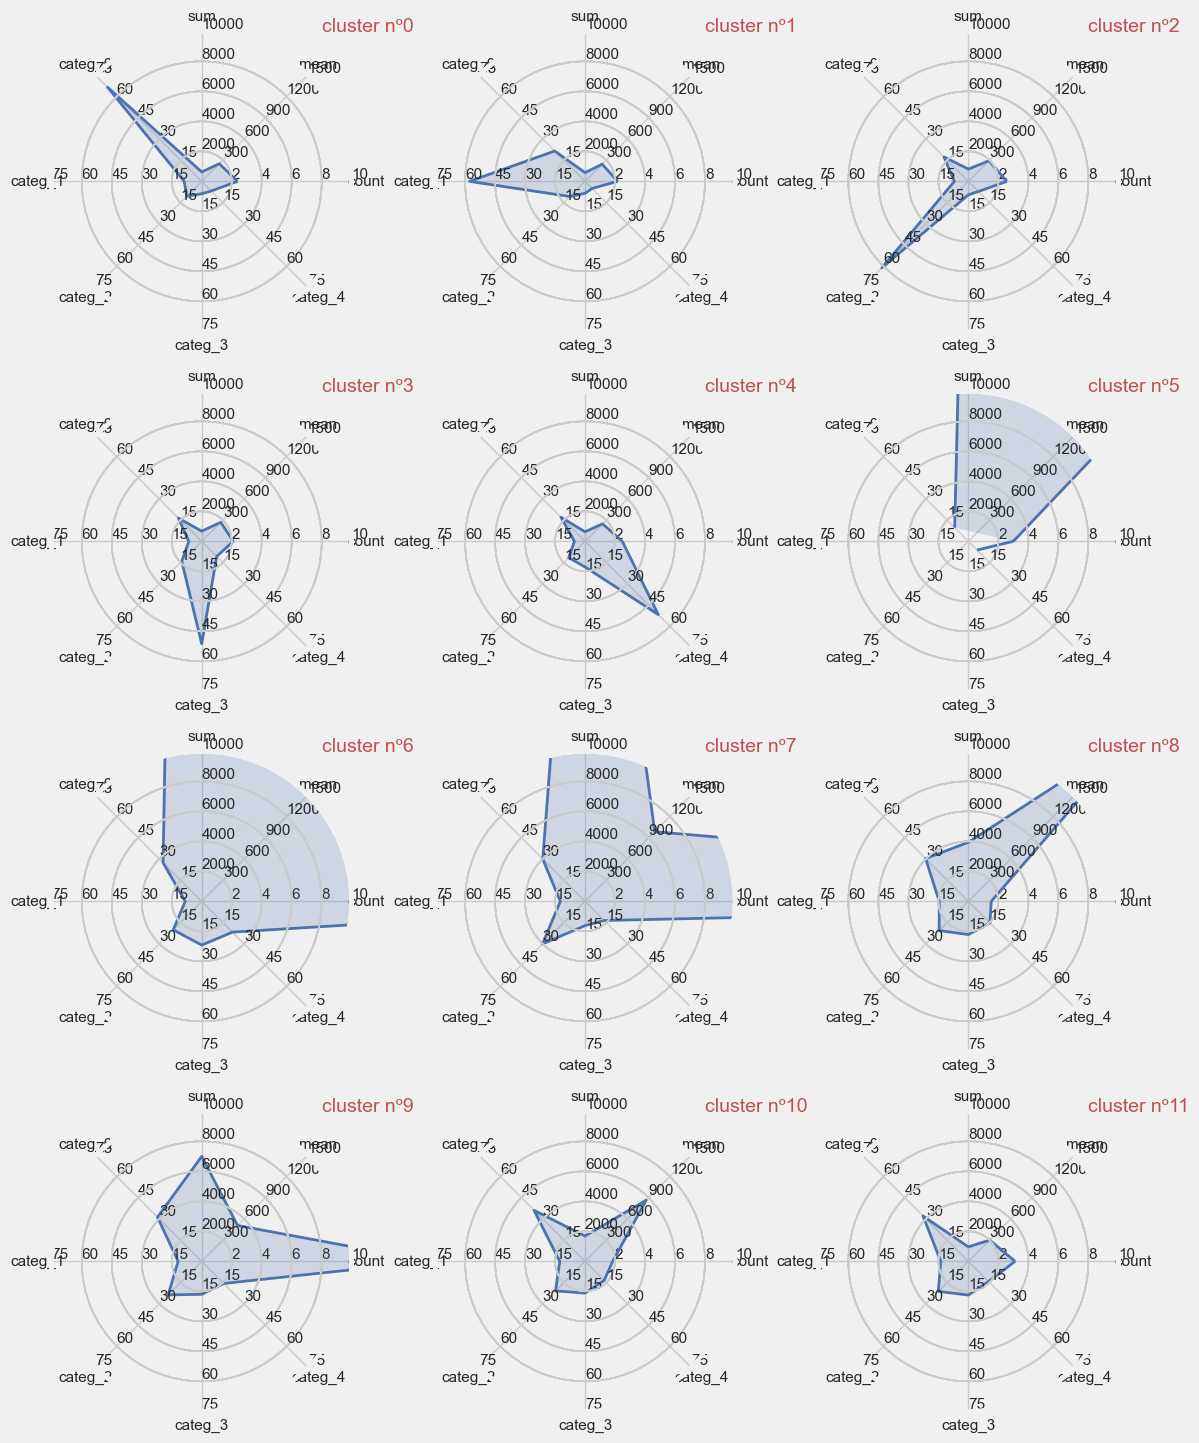

In [331]:
fig = plt.figure(figsize=(10,12))

attributes = ['count', 'mean', 'sum', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']
ranges = [[0.01, 10], [0.01, 1500], [0.01, 10000], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75]]
index  = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

n_groups = n_clusters ; i_cols = 3
i_rows = n_groups//i_cols
size_x, size_y = (1/i_cols), (1/i_rows)

for ind in range(n_clusters):
    ix = ind%3 ; iy = i_rows - ind//3
    pos_x = ix*(size_x + 0.05) ; pos_y = iy*(size_y + 0.05)            
    location = [pos_x, pos_y]  ; sizes = [size_x, size_y] 
    #______________________________________________________
    data = np.array(merged_df.loc[index[ind], attributes])    
    radar = RadarChart(fig, location, sizes, attributes, ranges)
    radar.plot(data, color = 'b', linewidth=2.0)
    radar.fill(data, alpha = 0.2, color = 'b')
    radar.title(title = 'cluster nº{}'.format(index[ind]), color = 'r')
    ind += 1

In [338]:
selected_customers['cluster'].nunique()

12

In [339]:
clusters_clients

array([ 6, 11,  0, ...,  0, 11,  0], dtype=int32)

In [340]:
merged_df

cluster      count          min           max          mean  \
0       0.0   2.388535   193.719851    317.734800    249.304957   
1       7.0   2.182203   191.346441    314.698432    242.911209   
2       4.0   2.570922   208.368901    381.361560    291.235026   
3       1.0   2.113475   204.665142    349.567482    269.759847   
4       8.0   2.491176   193.294088    313.547559    247.612809   
5       9.0   3.000000  3732.250000  30222.950000  12779.466667   
6       3.0  35.400000    44.824000  21205.894000   4595.414962   
7      10.0  58.388889    30.499444   4947.087222    985.196251   
8       6.0   1.530612  2057.989796   2732.566122   2379.214814   
9       5.0  15.244898    92.784439   1258.986633    507.130220   
10      2.0   1.853659   725.818850   1028.554568    864.801340   
11     11.0   3.121547   200.068979    416.396050    300.888892   

              sum    categ_0    categ_1    categ_2    categ_3    categ_4  \
0      625.182592  66.625201   8.757749  10.580782   6.194808   6.826730   
1      579.969873  21.456111  57.746814  10.744558   5.975109   5.021345   
2      816.547021  17.290715   6.990137  61.181711   6.741719   7.170064   
3      676.972340  16.505589   6.456458  14.113343  51.205010  10.620659   
4      634.868765  17.069851   5.323630  11.516428  12.820792  51.794089   
5    38338.400000   9.694954   0.000000  19.088655   0.000000   6.149970   
6   149845.156000  27.314526   8.236805  20.120099  21.898090  21.768008   
7    39259.095556  29.907764  12.358172  30.119789  12.159391  13.550450   
8     3937.499184  30.242059  14.590407  20.646286  16.631344  15.246881   
9     6997.988265  31.273932  11.801619  23.736288  16.485509  15.648839   
10    1687.985474  36.064645  12.664211  20.885686  15.877316  13.519924   
11     962.674193  32.086198  13.807457  21.254383  16.872344  14.293603   

    FirstPurchase  LastPurchase  size  
0      221.498938     89.747346   471  
1      222.033898     98.432203   236  
2      224.099291     90.755319   282  
3      221.414894     88.680851   282  
4      235.061765     96.608824   340  
5      297.500000     29.500000     2  
6      181.000000     78.600000     5  
7      195.277778     98.444444    18  
8      229.857143     96.877551    49  
9      234.214286     92.000000   196  
10     216.627178     76.592334   287  
11     219.330110     93.161602  1448

Classification of Customers

The objective will be to adjust a classifier that will classify consumers in the different client categories that were established in the previous section.

Define a class that allows to interface several of the functionalities common to different classifiers

In [476]:
class class_fit(object):
    def __init__(self, clf, params=None):
        if params:
            self.clf = clf(**params)
        else:
            self.clf = clf()

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def grid_search(self, parameters, kfold):
        self.grid = GridSearchCV(estimator = self.clf, param_grid = parameters, cv = kfold)

    def grid_fit(self, X, Y):
        self.grid.fit(X,Y)

    def grid_predict(self, X, Y):
        self.predictions = self.grid.predict(X)
        print(f'Precision: {100*metrics.accuracy_score(Y, self.predictions) :.2f} %')

Since the goal is to define the class to which a client belongs and this, as soon as its first visit, only keep the variables that describe the content of the basket, and do not take into account the variables related to the frequency of visits or variations of the basket price over time

In [467]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']
X = selected_customers[columns]
Y = selected_customers['cluster']

Split the data into train and test set

In [468]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42, test_size=0.2, shuffle=True)

In [469]:
len(x_train), len(x_test)

(2892, 724)

SUPPORT VECTOR MACHINE CLASSIFIER

In [470]:
svc = class_fit(clf=svm.LinearSVC, params={'C' : np.logspace(-2,2,10)})
svc.grid_search(kfold=5)

In [471]:
svc.grid_fit(x_train, y_train)

In [472]:
svc.grid.best_estimator_

LinearSVC(C=0.01)

In [473]:
svc.grid_predict(x_test, y_test)

Precision: 75.41 %


Confusion Matrix

In [409]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap = plt.cm.Blues):
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
        print(f'Normalised Confusion Matrix')
    else:
        print(f'Confusion matrix without normalization')
    
    plt.imshow(cm, interpolation= 'nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j]  > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

Confusion matrix without normalization


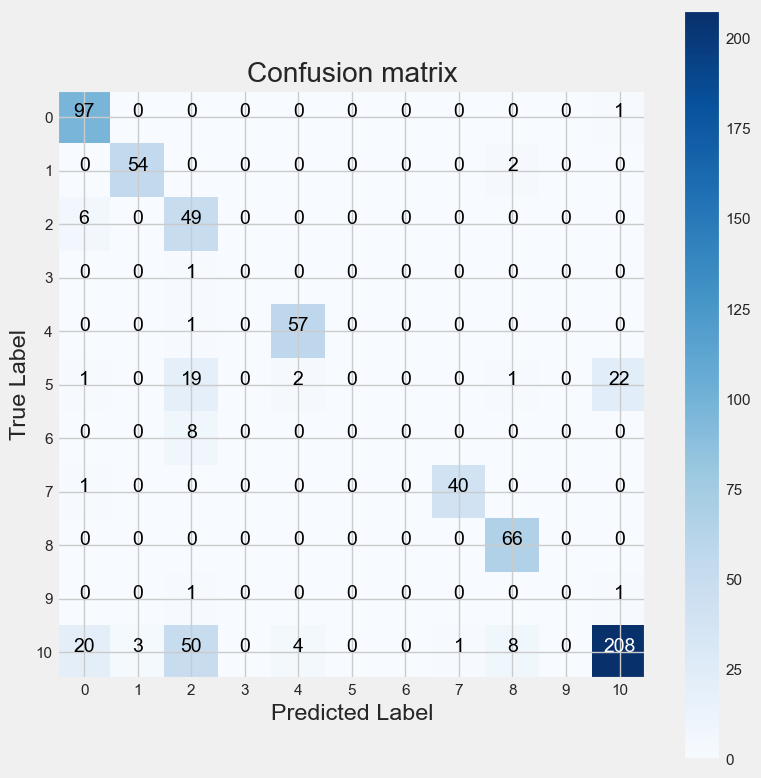

In [410]:
class_names = [i for i in range(11)]
cnf_matrix = confusion_matrix(y_test, svc.predictions)
np.set_printoptions(precision=2)
plt.figure(figsize = (8,8))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize = False, title='Confusion matrix')

LEARNING CURVE

A typical way to test the quality of a fit is to draw a learning curve. In particular, this type of curves allow to detect possible drawbacks in the model, linked for example to over- or under-fitting. This also shows to which extent the mode could benefit from a larger data sample.

In [411]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

/Users/meghaamar/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/meghaamar/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/meghaamar/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/meghaamar/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/meghaamar/Library/Python/3.9/lib/python/site

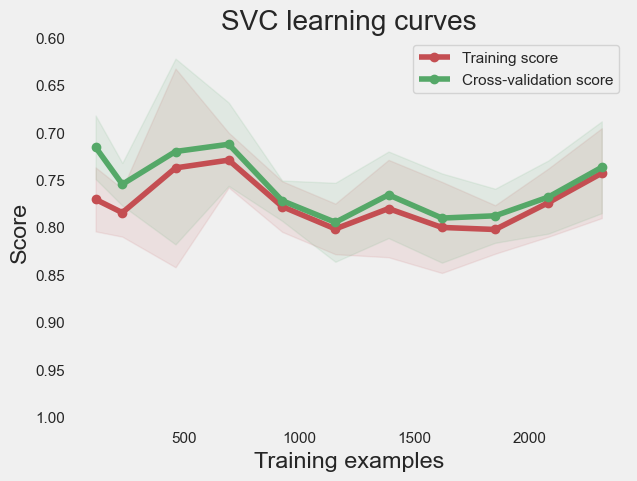

In [412]:
g = plot_learning_curve(svc.grid.best_estimator_,
                        "SVC learning curves", x_train, y_train, ylim = [1.01, 0.6],
                        cv = 5,  train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5,
                                                0.6, 0.7, 0.8, 0.9, 1])

On this curve, we can see that the train and cross-validation curves converge towards the same limit when the sample size increases. This is typical of modeling with low variance and proves that the model does not suffer from overfitting. Also, we can see that the accuracy of the training curve is correct which is synonymous of a low bias. Hence the model does not underfit the data.

LOGISTIC REGRESSION

In [413]:
logr = class_fit(clf=linear_model.LogisticRegression)
logr.grid_search(parameters=[{"C":np.logspace(-2,2,10)}], kfold=5)

In [414]:
logr.grid_fit(x_train, y_train)

In [415]:
logr.grid_predict(x_test, y_test)

Precision: 86.33 %


plot the learning curve

/Users/meghaamar/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/meghaamar/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

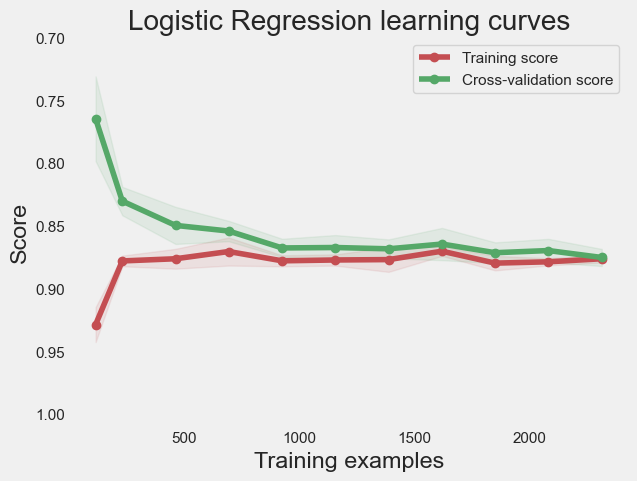

In [416]:
g = plot_learning_curve(logr.grid.best_estimator_,
                        "Logistic Regression learning curves", x_train, y_train, ylim = [1.01, 0.7],
                        cv = 5,  train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5,
                                                0.6, 0.7, 0.8, 0.9, 1])

K-Nearest Neighbours

In [417]:
knn = class_fit(clf=neighbors.KNeighborsClassifier)
knn.grid_search(parameters=[{'n_neighbors' : np.arange(1,50,1)}], kfold=5)
knn.grid_fit(x_train,y_train)
knn.grid_predict(x_test,y_test)

Precision: 77.90 %


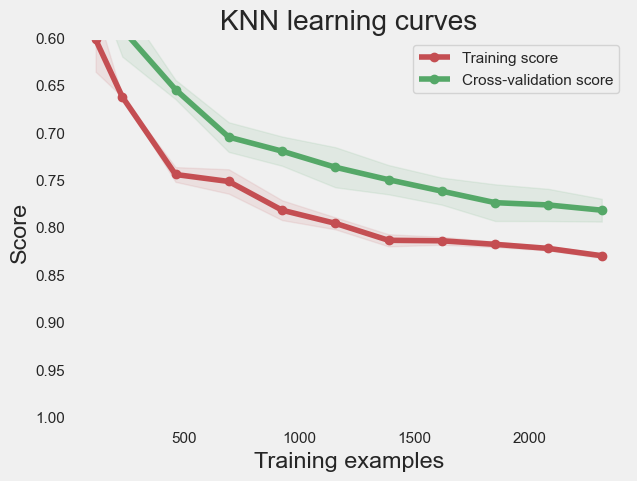

In [418]:
g = plot_learning_curve(knn.grid.best_estimator_,
                        "KNN learning curves", x_train, y_train, ylim = [1.01, 0.6],
                        cv = 5,  train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5,
                                                0.6, 0.7, 0.8, 0.9, 1])

DECISION TREE

In [419]:
dt = class_fit(clf=tree.DecisionTreeClassifier)
dt.grid_search(parameters=[{'max_features': ['auto', 'sqrt', 'log2'],
              'ccp_alpha': [0.1, .01, .001],
              'max_depth' : [5, 6, 7, 8, 9],
              'criterion' :['gini', 'entropy']
             }], kfold=5)
dt.grid_fit(x_train, y_train)
dt.grid_predict(x_test, y_test)

Precision: 74.86 %


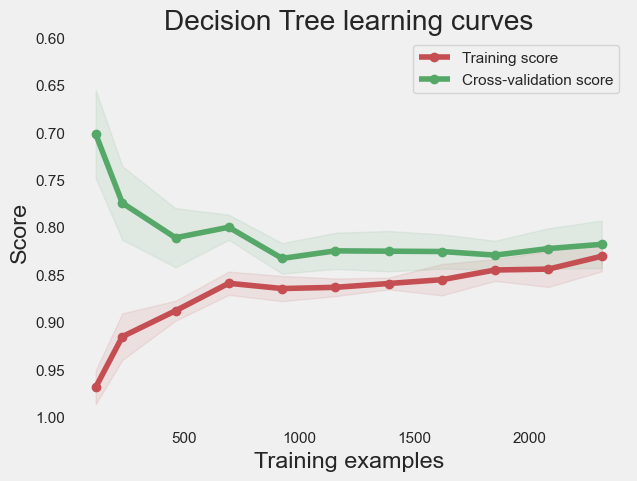

In [420]:
g = plot_learning_curve(dt.grid.best_estimator_,
                        "Decision Tree learning curves", x_train, y_train, ylim = [1.01, 0.6],
                        cv = 5,  train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5,
                                                0.6, 0.7, 0.8, 0.9, 1])

RANDOM FOREST

In [477]:
rf =class_fit(clf=ensemble.RandomForestClassifier)
param_grid = {'criterion' : ['entropy', 'gini'], 'n_estimators' : [20, 40, 60, 80, 100],
               'max_features' :['sqrt', 'log2']}
rf.grid_search(parameters= param_grid, kfold=5)
rf.grid_fit(x_train, y_train)
rf.grid_predict(x_test, y_test)

Precision: 85.64 %


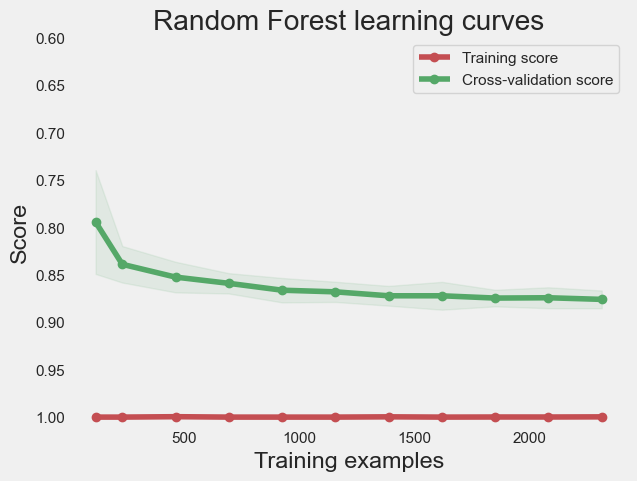

In [474]:
g = plot_learning_curve(rf.grid.best_estimator_,
                        "Random Forest learning curves", x_train, y_train, ylim = [1.01, 0.6],
                        cv = 5,  train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5,
                                                0.6, 0.7, 0.8, 0.9, 1])

ADA BOOST CLASSIFIER

In [423]:
ada = class_fit(clf = ensemble.AdaBoostClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
ada.grid_search(parameters = param_grid, kfold=5)
ada.grid_fit(x_train, y_train)

ada.grid_predict(x_test,y_test)

Precision: 53.04 %


In [424]:
ada.grid.best_estimator_

AdaBoostClassifier(n_estimators=10)

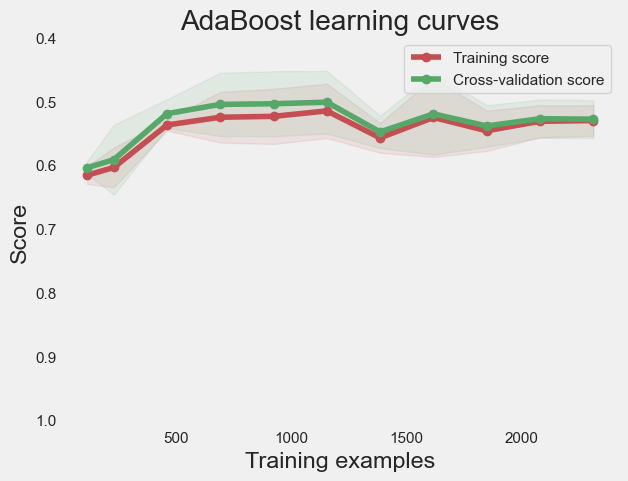

In [425]:
g = plot_learning_curve(ada.grid.best_estimator_, "AdaBoost learning curves", x_train, y_train,
                        ylim = [1.01, 0.4], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

GRADIENT BOOSTING CLASSIFIER

In [426]:
gb = class_fit(clf=ensemble.GradientBoostingClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
gb.grid_search(parameters= param_grid,kfold=5)
gb.grid_fit(x_train, y_train)
gb.grid_predict(x_test, y_test)

Precision: 85.77 %


In [427]:
gb.grid.best_estimator_

GradientBoostingClassifier(n_estimators=40)

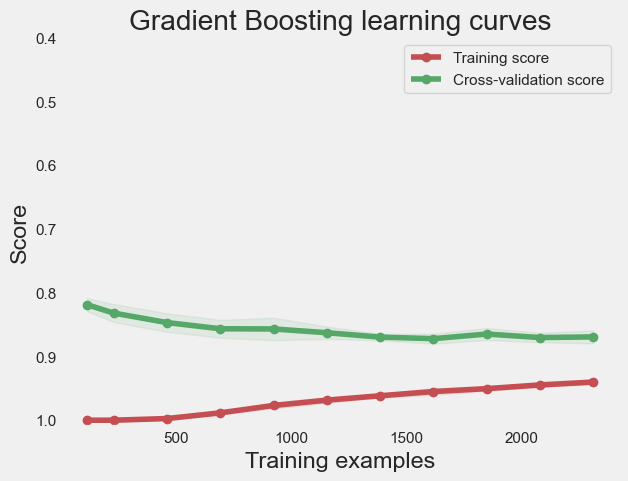

In [436]:
g = plot_learning_curve(gb.grid.best_estimator_, "Gradient Boosting learning curves", x_train, y_train,
                        ylim = [1.01, 0.4], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

Finally, the results of the different classifiers presented in the previous sections can be combined to improve the classification model. This can be achieved by selecting the customer category as the one indicated by the majority of classifiers. To do this, use the VotingClassifier method of the sklearn package

In [430]:
rf_best  = ensemble.RandomForestClassifier(**rf.grid.best_params_)
gb_best  = ensemble.GradientBoostingClassifier(**gb.grid.best_params_)
svc_best = svm.LinearSVC(**svc.grid.best_params_)
dt_best  = tree.DecisionTreeClassifier(**dt.grid.best_params_)
knn_best = neighbors.KNeighborsClassifier(**knn.grid.best_params_)
logr_best  = linear_model.LogisticRegression(**logr.grid.best_params_)

In [432]:
votingc = ensemble.VotingClassifier(estimators=[('rf', rf_best), ('gb', gb_best), ('knn', knn_best)], voting='soft')

In [433]:
votingc = votingc.fit(x_train, y_train)


In [435]:
predictions = votingc.predict(x_test)
print(f'Precision: {100*metrics.accuracy_score(y_test, predictions):.2f} %')

Precision: 86.88 %


TESTING PREDICTIONS

In [439]:
basket_price = basket_price_test.copy(deep=True)

In [440]:
transactions_per_user=basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count','min','max','mean','sum'])
for i in range(5):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = basket_price.groupby(by=['CustomerID'])[col].sum() /\
                                            transactions_per_user['sum']*100

transactions_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['CustomerID'])['categ_0'].sum()

#_______________________
# Correcting time range
transactions_per_user['count'] = 5 * transactions_per_user['count']
transactions_per_user['sum']   = transactions_per_user['count'] * transactions_per_user['mean']

transactions_per_user.sort_values('CustomerID', ascending = True)[:5]

CustomerID  count      min      max     mean       sum     categ_0  \
0      12347     10   224.82  1294.32   759.57   7595.70   25.053649   
1      12349      5  1757.55  1757.55  1757.55   8787.75   52.138488   
2      12352      5   311.73   311.73   311.73   1558.65   60.084047   
3      12356      5    58.35    58.35    58.35    291.75  100.000000   
4      12357      5  6207.67  6207.67  6207.67  31038.35   26.686341   

     categ_1    categ_2    categ_3    categ_4  
0  12.696657  32.343299  24.271627   5.634767  
1   4.513101  12.245455  10.713778  20.389178  
2   6.672441   8.735123   7.217785  17.290604  
3   0.000000   0.000000   0.000000   0.000000  
4   5.089832  14.684737  28.350089  25.189000

In [446]:
transactions_per_user.columns

Index(['CustomerID', 'count', 'min', 'max', 'mean', 'sum', 'categ_0',
       'categ_1', 'categ_2', 'categ_3', 'categ_4'],
      dtype='object')

In [448]:
list_cols = ['count', 'min', 'max', 'mean', 'sum', 'categ_0',
       'categ_1', 'categ_2', 'categ_3', 'categ_4']
matrix_test = np.asarray(transactions_per_user[list_cols])
scaled_test_matrix = scaler.transform(matrix_test)

In [449]:
y = kmeans.predict(scaled_test_matrix)

In [452]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4' ]
x = transactions_per_user[columns]

examine the predictions of the different classifiers

In [453]:
classifiers = [(svc, 'Support Vector Machine'),
                (logr, 'Logostic Regression'),
                (knn, 'k-Nearest Neighbors'),
                (dt, 'Decision Tree'),
                (rf, 'Random Forest'),
                (gb, 'Gradient Boosting')]
#______________________________
for clf, label in classifiers:
    print(30*'_', '\n{}'.format(label))
    clf.grid_predict(x, y)

______________________________ 
Support Vector Machine
Precision: 67.38 %
______________________________ 
Logostic Regression
Precision: 70.39 %
______________________________ 
k-Nearest Neighbors
Precision: 65.82 %
______________________________ 
Decision Tree
Precision: 62.03 %
______________________________ 
Random Forest
Precision: 71.37 %
______________________________ 
Gradient Boosting
Precision: 70.66 %


 it is possible to improve the quality of the classifier by combining their respective predictions. At this level, I chose to mix Random Forest, Gradient Boosting and k-Nearest Neighbors predictions because this leads to a slight improvement in predictions

In [457]:
predictions = votingc.predict(x)
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(y, predictions)))

Precision: 72.03 % 
